<a href="https://colab.research.google.com/github/mbc2009/Inferno/blob/main/MCF/Image%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Setup and Imports

Import all necessary libraries and ensure that the environment is correctly set up

In [1]:
%%capture
%%bash
# update package
yes | pip uninstall pillow
yes | pip install pillow

# remove unnecessary
cd /content
rm -rf *

# install package
pip install opencv-python pillow
pip install segmentation_models_pytorch
pip install kaggle
pip install dropbox
pip install scikit-image

In [2]:
# basic import
import  os, sys, time, math, random, math, psutil
from  typing  import List, Tuple
from dropbox import  Dropbox
from pycocotools.coco  import COCO
from tqdm   import  tqdm
from matplotlib import  pyplot as plt
from matplotlib import  colors as mcolors
from matplotlib.patches import Rectangle
import  numpy as np
import  pandas as pd
import  xarray as xr
import  multiprocessing as mp
import  zipfile
import  warnings
import  shutil
import  json
from functools import lru_cache
from multiprocessing import Pool, set_start_method
import concurrent.futures
import cv2

from skimage import  io
from scipy import  interpolate
from scipy.interpolate import  RegularGridInterpolator
from scipy.ndimage import  generic_filter
from PIL import  Image

import torch
from torch  import nn
from torch.nn import  functional  as F
import torch.optim                                 as optim
from torch.utils.data import  Dataset, DataLoader, TensorDataset, random_split, Subset
from torchvision import  transforms, models
from torchvision.transforms  import  *
import torchvision.transforms.functional as TF
import kagglehub


In [3]:
# download database
original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation") # EMPS
print("Original Path to dataset files:", original_path)

path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")

!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 17.4MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [4]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


In [5]:
# check hardware
print(f"CPU core #:\t{os.cpu_count()}")
print(f"CPU threads #:\t{psutil.cpu_count(logical=True)}")
print(f"Total memory:\t\t{psutil.virtual_memory().total / (1024**3):.2f} GB")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"available GPU #:\t{gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i+1}:\t\t{gpu_name}")
else:
    print("No available GPU")

CPU core #:	12
CPU threads #:	12
Total memory:		83.48 GB
available GPU #:	1
GPU 1:		NVIDIA A100-SXM4-40GB


# 2.Configuration

class or dictionary to make hyperparameters easily tunable

Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [6]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Determine data cleaning directory
    patched_image_folder = os.path.join(path, 'images_with_patch')
    patched_mask_folder  = os.path.join(path, 'segmaps_with_patch')


    # Determine COCO file output dirctory
    coco_output_folder = os.getcwd()

    # Training hyperparameters
    num_epochs      = 20
    batch_size      = 16
    learning_rate   = 2e-4
    momentum        = 0.9
    weight_decay    = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride      = 1
    padding     = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
config = Config()
print(f'current device = {config.device}')

current device = cuda


In [8]:
print(config.image_folder)

/content/electron-microscopy-particle-segmentation/images


# 3.Dataset preparation


## 3.1 Dataset Filtering
- remove dissatisfied data

In [9]:
%%capture
# download the image_not_used folder
folder_name = "image_not_used"
!git clone https://github.com/iceaiai/Image-segmentation.git
!mv Image-segmentation/{folder_name} .
!rm -rf Image-segmentation

In [10]:
# def work path
work_dir = os.path.join(os.getcwd(),folder_name)

# def a function to collect file names
def get_filenames_from_folder(folder_path:str)->list:
    """
    Reads all filenames within a folder, excluding file extensions,
    and compiles them into a list.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        list: A list of filenames without extensions.
    """
    filenames = []
    for filename in os.listdir(folder_path):
        base_name, extension = os.path.splitext(filename)  # Split the filename into base name and extension
        filenames.append(base_name)
    return filenames

# Get the list of filenames
work_dir = os.path.join(os.getcwd(), folder_name)
image_not_used_list = get_filenames_from_folder(work_dir)

# Print the length of the image_not_used_list
original_count = len(image_not_used_list)
print(f"Delete list length: {original_count}")

Original count: 31


In [11]:
def delete_images_from_folders(image_folder, mask_folder, image_not_used_list)->int:
    """
    Deletes images from two folders based on a list of filenames.

    Args:
        image_folder (str): Path to the image folder.
        mask_folder (str): Path to the mask folder.
        image_not_used_list (list): List of filenames to delete (without extension).

    Returns:
        int: Number of images deleted.
    """

    deleted_count = 0  # Initialize the count of deleted images or mask

    # Iterate through the list of filenames to delete
    for image_name in image_not_used_list[:]:
        image_path = os.path.join(image_folder, image_name + ".png")
        mask_path  = os.path.join(mask_folder,  image_name + ".png")

        try:
            # Attempt 1: delete the image file
            os.remove(image_path)
            #print(f"Deleted {image_name} from image folder ✅")

            # Attempt 2: delete the mask file
            os.remove(mask_path)
            #print(f"Deleted {image_name} from mask folder ✅")

            # Increment the deleted count
            deleted_count += 1

        except FileNotFoundError:
            print(f"Error: {image_name} not found in one or both folders ")

    return deleted_count  # Return the total number of images/ mask deleted

# Call the function to delete images
deleted_count = delete_images_from_folders(config.image_folder, config.mask_folder, image_not_used_list)

# Print the total number of deleted images
print(f"Total images/masks deleted: {deleted_count}")

Total images/masks deleted: 31


In [12]:
checker = False

# Check 1: Wether the oringal count = deleted count
if deleted_count == original_count:
  print('All requested image/mask were deleted ✅')
  checker = True
else:
  print('Not all requested image/mask were deleted ❌')


# Check 2: See if files have been actually deleted
for image_name in image_not_used_list:
    image_path = os.path.join(config.image_folder, image_name + ".png")
    mask_path  = os.path.join(config.mask_folder, image_name + ".png")

    if not os.path.exists(image_path) and not os.path.exists(mask_path):
        #print(f"{image_name} has been deleted from both image and mask folders ✅")
        pass
    else:
        checker = False
        print(f"{image_name} still exists in either image or mask folder (or both) ❌")

All requested image/mask were deleted ✅


In [13]:
# if delete task completed, remove the folder
if checker:
  shutil.rmtree(work_dir)

## 3.2 Data cleaning
- Add patches to mask & images

### 3.1.1 Define Classes

In [14]:
class Graph():
  '''
  A class to represent elemntray Graph

  Usage:
    plot(Graph): plot image
    print(Graph): print image info
    data[x,y]: The image pixel RGB value at (x,y) s a NumPy array

  Attributes:
    data (ndarray): The Graph data loaded as a NumPy array (m x n x 3)
    boundaries (dict): The boundary of the Graph
    vertices (list): The four vertices of the Graph (xmin, ymin, xmax, ymax)
  '''

  def __init__(self, data: np.ndarray, xy_limits=None):
    '''
    input:
      xy_limits (list): The x y limits of the Graph (x_min, x_max, y_min, y_max)
      data (ndarray): The Graph data loaded as a NumPy array
      vertices (list): The four vertices of the Graph (xmin, ymin, xmax, ymax)

    return:
      instance of a Graph
    '''
    # data info
    self.data           = data
    self.dtype          = self.data.dtype
    self.shape          = self.data.shape
    self.size           = self.data.size
    self.xy_limits      = xy_limits
    self.vertices       = self.get_vertices()
    self.boundaries     = self.get_boundaries()

  def __str__(self) -> str:
    graph_info = f'{type(self).__name__} info:\n' \
                 f'size           = {self.size}\n' \
                 f'shape          = {self.data.shape}\n' \
                 f'data type      = {self.data.dtype}\n' \
                 f'variable type  = {type(self.data)}\n'\
                 f'\n'
    return graph_info

  def get_vertices(self) -> list[tuple]:
      """
      Calculate vertices from xylimits.

      Returns:
          list: List of vertices as list [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
      """
      if self.xy_limits is None:
          # Default boundary (using image shape)
          x_min, y_min  = 0, 0
          x_max, y_max  = int(self.shape[0]), int(self.shape[1])
      else:
          # User-provided boundary
          x_min = int(self.xy_limits[0])
          x_max = int(self.xy_limits[1])
          y_min = int(self.xy_limits[2])
          y_max = int(self.xy_limits[3])

      # Calculate vertices (Clockwise in matrix, counter-clockwise in Graph)
      vertices = [(x_min, y_min),
                  (x_max, y_min),
                  (x_max, y_max),
                  (x_min, y_max)]
      # update x y limit
      self.xy_limits = (x_min, x_max, y_min, y_max)
      return vertices

  def get_boundaries(self) -> dict:
      """
      Get the boundary of the image.
      """
      boundaries = {}
      boundaries['x_min'] = int(self.vertices[0][0])
      boundaries['x_max'] = int(self.vertices[1][0])
      boundaries['y_min'] = int(self.vertices[0][1])
      boundaries['y_max'] = int(self.vertices[2][1])
      boundaries['x_len'] = abs(int(boundaries['x_max'] - boundaries['x_min']))
      boundaries['y_len'] = abs(int(boundaries['y_max'] - boundaries['y_min']))
      boundaries['diagonal'] = np.sqrt(boundaries['x_len']**2 + boundaries['y_len']**2)
      return boundaries

  def show(self) -> None:
      '''
      plot the image
      '''
      plt.imshow(self.data)
      plt.show()

class Patch(Graph):
  '''
  A class to represent Patch

  Input:
    xy_limits ([x_min, x_max, y_min, y_max]): The x y limits of the Patch
    x_min/ x_max: row of the Patch pixel matrix
    y_min/ y_max: column of the Patch pixel matrix
    color_mode (str): the coloring mode of the patch, 'black' or 'BinaryInterpolation'

  Attributes:
    host_graph (Graph): The Graph instance that patching to

  Usage:
    plot(Patch): plot image
    print(Patch): print image info

  Note:
    Initial Patch will be black,
    Patch will be colored after add_patch(Patch)
  '''

  def __init__(self, xy_limits: list, color_mode: str):

    # Basic info
    self.xy_limits  = xy_limits
    self.vertices   = self.get_vertices()
    self.boundaries = self.get_boundaries()

    # Iinitialization （as black patch）
    self.color_mode = 'black'
    self.data       = self.get_colored()
    super().__init__(data=self.data, xy_limits=xy_limits)

    # Coloring settings (for add_Patch(Patch))
    self.color_mode = color_mode
    self.host_graph: Graph

  def __str__(self) -> str:
    graph_info = super().__str__()
    patch_info = f'boundary       = {self.boundaries}\n'\
                 f'vertices       = {self.vertices}\n'\
                 f'\n'
    return graph_info + patch_info

  def get_colored(self) -> np.ndarray:

    # set ndarry shape for Graph
    x_len, y_len    = self.boundaries['x_len'], self.boundaries['y_len']
    RGB_shape       = (x_len, y_len, 3)
    GrayScale_shape = (x_len, y_len)


    if self.color_mode == 'Transparent':
      # colored with original inpyt host image
      data = self.host_graph.data.copy()
      data = self.get_taylored(data) # tayloring the size

    elif self.color_mode == 'black':
      # colored with pure plack
      data = np.zeros(RGB_shape)


    elif self.color_mode == 'BinaryInterpolation_4Points':
      # colored with Binary interpolation
      data = bilinear_interpolation_4Points(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size

    elif self.color_mode == 'BinaryInterpolation_4Bonds':
      # colored with Bilinear interpolation
      data = bilinear_interpolation_4Bonds(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size


    elif self.color_mode == 'BinaryInterpolation_Sliding':
      # colored with Bilinear interpolation
      data = bilinear_interpolation_Sliding(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size


    elif self.color_mode == 'GrayScale_background': # for mask only
      # colored for Mask only
      marker = 0  # colored as background
      data = np.full(GrayScale_shape, marker)


    elif self.color_mode == 'GrayScale_out': # for mask only
      # colored for Mask only
      marker = np.max(self.host_graph.data) + self.host_graph.patch_num + 1
      # print(marker)
      data = np.full(GrayScale_shape, marker)


    else:
      error_message = f'Color mode:\n'\
                      f'black, Transparent\n'\
                      f'BinaryInterpolation_(4oints,4Bonds,Sliding)\n'\
                      f'GrayScale_(background,out)'
      raise ValueError(error_message)


    # update
    self.data = data

    return data

  def get_taylored(self, data):
    # tayloring the patch to desired size
    data = data[self.boundaries['x_min']:self.boundaries['x_max'],
                self.boundaries['y_min']:self.boundaries['y_max']]
    return data

  def show(self) -> None:
      '''
      plot the Patch itself
      '''
      plt.imshow(self.data)
      plt.show()

class Image(Graph):
  '''
  A class to represent image

  Usage:
    add_patch(Patch): add single patch to the host Image
    get_data_with_patch(): get the data with patches

  Attributes:
    path (str): path to the image
    name (str): name of the image
    patch_list (list): list of patches of the host Image
    patch_num (int): number of patches of the host Image
  '''

  def __init__(self, path: str):
    '''
    Parameters:
      path (str): path to the image

    return:
      instance of Image
    '''

    # Basic info
    self.path       = path
    self.name       = path.split("/")[-1]
    self.data       = io.imread(self.path)

    # Initialization
    super().__init__(data=self.data)

    # Recording patches
    self.patch_list      = []  # list of patches of the host Image
    self.patch_num       = 0   # number of patches of the host Image
    self.data_with_patch = self.data.copy() # Images with patches

  def attach_patch(self, patch: Patch):
    '''
      Add single patch to the host Image
    '''
    # Assgin the host image to the patch
    patch.host_graph = self

    # Color the attached patch
    patch.get_colored()

    # Attach the patch to the host image
    self.patch_list.append(patch)
    self.patch_num = len(self.patch_list)

    # Update the host image after attachment
    self.get_data_with_patch()

  def get_data_with_patch(self):
    '''
      Get the Image data with patches
    '''

    for patch_i in self.patch_list:
        # Get patch boundaries
        x_min = patch_i.boundaries['x_min']
        x_max = patch_i.boundaries['x_max']
        y_min = patch_i.boundaries['y_min']
        y_max = patch_i.boundaries['y_max']

        # Overlay patch data onto the main image data
        self.data_with_patch[x_min:x_max, y_min:y_max] = patch_i.data

  def show(self, show_pathces=False) -> None:
      '''
      plot the image

      Parameters:
      show_pathces (bool): whether to show patches or not
      '''
      if show_pathces:
        self.get_data_with_patch()
        plt.imshow(self.data_with_patch)
      else:
        plt.imshow(self.data)
      plt.show()

  def __str__(self) -> str:
    graph_info = super().__str__()
    image_info = f'path           = {self.path}\n' \
                 f'name           = {self.name}\n'\
                 f'boundary       = {self.boundaries}\n'\
                 f'vertices       = {self.vertices}\n'\
                 f'patch_list     = {self.patch_list}\n'\
                 f'patch_num      = {self.patch_num}\n'\
                 f'\n'
    return graph_info + image_info

class Mask(Image):
  '''
  A class to represent mask

  Usage:
    plot(Mask): plot image
    print(Mask): print image info
    data[x,y]: The image    value at (x,y) s a NumPy
  '''
  def __init__(self, path: str):
    '''
    Parameters:
      path (str): path to the mask

    return:
      instance of Mask
    '''
    super().__init__(path)
    self.objects_list = [] # a dict collected all objects

  def __str__(self) -> str:
    return super().__str__()

  @lru_cache(maxsize=None)
  def find_objects(self) -> list:
    '''
    functions to extract object info from mask
    Parameters:
      self.objects_dict[i] := dict for recording all object_i
    '''
    ## np.ndarray -> xr.DataArray
    data = self.data
    da = xr.DataArray(data, dims=['x', 'y'])

    ## find the total quantity of objects
    obj_count = int(da.max().data)

    ## create and collect all objects
    for i in range(1, obj_count + 1):
        # create
        object_i = Object(i, da)
        # record
        self.objects_list.append(object_i)

    return self.objects_list

  def show_objects(self):
      """
      Displays the original image and its objects in a single figure.

      Args:
          data (np.ndarray): The input matrix data.
          show_data_array (bool, optional): Whether to display data array info. Defaults to False.
      """

      # Extract objects using `find_objects`
      objects_list          = self.find_objects()
      min_value, max_value  = self.data.min(), self.data.max()
      num_objects           = len(objects_list)

      # Calculate the arrangement of subplots based on the number of objects
      cols = int(np.ceil(np.sqrt(num_objects)))
      rows = int(np.ceil(num_objects / cols))

      # Unify color rendering
      cmap_viridis    = plt.get_cmap('viridis')
      colors_viridis  = cmap_viridis(np.linspace(0, 1, 256))
      cmap_custom     = mcolors.ListedColormap(colors_viridis)

      # Create a figure and subplots using `matplotlib.pyplot.subplots`
      fig, axes = plt.subplots(rows + 1, cols, figsize=(10, 10))

      # Display the original image in the first subplot
      #axes[0, 0].imshow(data, cmap='viridis')
      axes[0, 0].imshow(self.data, cmap=cmap_custom, vmin=min_value, vmax=max_value)
      axes[0, 0].set_title('Original Image')

      # Hide blank sibplot
      for j in range(1,cols):
          axes[0, j].axis('off')

      # Display the objects in the remaining subplots
      obj_index = 0
      for i in range(1, rows + 1):
          for j in range(cols):
              if obj_index < num_objects:
                  obj_i = objects_list[obj_index]

                  # display image
                  axes[i, j].imshow(obj_i.data, cmap=cmap_custom, vmin=min_value, vmax=max_value)

                  # show border
                  for k in range(0, len(obj_i.border), 2):  # Iterate in steps of 2
                      x = obj_i.border[k]
                      y = obj_i.border[k + 1]
                      axes[i, j].plot(x, y, marker='o', markersize=0.5, color='orange')

                  # show bbox
                  rect = Rectangle((obj_i.bbox[0], obj_i.bbox[1]),  # Use bbox[0] and bbox[1] for x and y
                                    obj_i.bbox[2],  # Use bbox[2] for width
                                    obj_i.bbox[3],  # Use bbox[3] for height
                                    linewidth=1, edgecolor='yellow', facecolor='none')
                  axes[i, j].add_patch(rect)

                  # display info
                  title = f'Object {obj_i.id}'
                  axes[i, j].set_title(title)

                  obj_index += 1
              else:
                  axes[i, j].axis('off')  # Turn off extra subplots

      plt.tight_layout()  # Adjust subplot layout
      plt.show()

In [15]:
class Object():
    def __str__(self):
      info =  f'Object ID:     {self.id}\n'
      info += f'Object area:   {self.area}\n'
      info += f'Object bbox:   {self.bbox}\n'
      info += f'Object border: {self.border}\n'
      return info

    def __init__(self, id, da):
      '''
      Parameters:
        mask:   parent mask instance
        id:     id of the object
        data:   data array of the mask, in a format of xr.DataArray
        bounds: the boundary of the object
        area:   the area of the object
        border: the coordinates of the pixel on the boarder between object instance and background
      '''

      # 0️⃣ Assign basic attributes
      self.id  = id   # ID, begin from 0

      # 1️⃣ Extract pixEEl of object_i and keep original size, fill with 0 outside
      self.data = xr.where(da == id, da, 0)

      # 2️⃣ Extract box boundary and form bbox directly
      rows, cols = np.where(self.data)  # 获取非零元素坐标
      if rows.size > 0 and cols.size > 0:
          x_min = rows.min()
          x_max = rows.max()
          y_min = cols.min()
          y_max = cols.max()

          # Form bbox
          self.bbox = [y_min, x_min, y_max - y_min, x_max - x_min]

      else:
          self.bbox = [0, 0, 0, 0] # If no object pixels, bbox is [0, 0, 0, 0]

      # 3️⃣ extract the coordinates of the pixel on the border
      border_points = self.find_Border(self.data)
      self.border = []
      for point in border_points:
          self.border.extend([int(point[0]), int(point[1])])  # Flatten the list


      # 4️⃣ calculate object's area（# of non-zero elements）
      self.area = int(np.count_nonzero(self.data))


    def find_Border(self, object_da):
      # 将 xarray.DataArray 转换为 NumPy 数组
      object_np = object_da.values

      # 执行膨胀操作
      kernel = np.ones((3, 3), np.uint8)
      dilated = cv2.dilate(object_np, kernel, iterations=1)

      # 将膨胀后的图像与原始图像相减，得到边界
      border = dilated - object_np

      # 提取边界点的坐标
      rows, cols = np.where(border)
      edge_points = list(zip(cols, rows))

      return edge_points

### 3.1.2 Define Functions

helper functions

In [16]:
def add_average_border(image: np.ndarray) -> np.ndarray:
  """Calculates the average RGB values and applies them to the image border. Doing this is to avoid the turbulence from the boarder color (pure white or pure black)

  Args:
    image: The input RGB image as an ndarray.

  Returns:
    The image with the average RGB border.
  """

  # Calculate the average RGB values
  average_color = np.mean(image, axis=(0, 1), dtype=int)

  # Apply the average color to the image border
  image[0,  :, :] = average_color  # Top border
  image[-1, :, :] = average_color  # Bottom border
  image[:,  0, :] = average_color  # Left border
  image[:, -1, :] = average_color  # Right border

  return image


def zip_folder(folder_path, output_path):
  """
  Compress folder to zip file
  """
  with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

algorithm for cleaning the labeling (legend, scale bar, notation, title)

In [17]:
def bilinear_interpolation_4Points(img: np.ndarray, xy_limits: list):
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """
    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    width, height = x_max - x_min + 1, y_max - y_min + 1
    _, _, channels = img.shape
    interpolated_img = np.zeros_like(img) # host image


    # Loop over R, G, B channels
    for c in range(channels):

        # Fetch pixel values from the 4 fixed points
        Q11 = img[x_min, y_min, c]  # Top-left
        Q12 = img[x_max, y_min, c]  # Top-right
        Q21 = img[x_min, y_max, c]  # Bottom-left
        Q22 = img[x_max, y_max, c]  # Bottom-right

        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):

                # Compute interpolation weights
                weight_x = (x - x_min) / width
                weight_y = (y - y_min) / height

                # Bilinear interpolation formula
                T = Q11 * (1-weight_x) + weight_x * Q12
                B = Q21 * (1-weight_x) + weight_x * Q22
                P = B * weight_y + T * (1-weight_y)

                interpolated_img[x, y, c] = P


    return interpolated_img


# major method
def bilinear_interpolation_4Bonds(img: np.ndarray, xy_limits: list):
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Note:
        This method uses 4 sliding boundaries rather than 4 fixed corner points.
        The 4 points are projections of the current point to the top, bottom, left, and right edges.

    Parameters:
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """
    # Initiation
    img = img.copy()
    x_min, x_max, y_min, y_max = xy_limits
    height, width = x_max - x_min + 1, y_max - y_min + 1
    _, _, channels = img.shape
    interpolated_img = np.zeros_like(img)

    # add border (for dealing with rigid huge label)
    img = add_average_border(img)

     # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max+1):
            for y in range(y_min, y_max+1):

                # Compute interpolation weights
                weight_x = (x-x_min) / height
                weight_y = (y-y_min) / width

                # Fetch pixel values from sliding projection points
                Q_Top   = img[x_min,  y,      c]  # Top boundary
                Q_Bot   = img[x_max,  y,      c]  # Bottom boundary
                Q_Left  = img[x,      y_min,  c]  # Left boundary
                Q_Right = img[x,      y_max,  c]  # Right boundary

                # Bilinear interpolation formula using boundary projections
                H = Q_Top * (1 - weight_x) + Q_Bot  * weight_x
                V = Q_Left  * (1 - weight_y) + Q_Right * weight_y

                interpolated_img[x, y, c] = (H+V)/2

    return interpolated_img


def bilinear_interpolation_Sliding(img: np.ndarray, xy_limits: list, WindowScale=0.8) -> np.ndarray:
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        xy_llimits (list): [x_min, x_max, y_min, y_max]
        WindowScale (int): the scale of the sliding window, higher means extract nearer neighboring pixels
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """

    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    height, width  = x_max - x_min + 1, y_max - y_min + 1
    full_height, full_width, channels = img.shape
    interpolated_img = np.zeros_like(img) # host image

    # Determing sliding window geometry
    window_width  = width  // WindowScale
    window_height = height // WindowScale

    # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):

                # Make sliding window geometry adaptive
                window_x_min = max(int(x - 0.5 * window_height), 0)
                window_x_max = min(int(x + 0.5 * window_height), full_height-1)
                window_y_min = max(int(y - 0.5 * window_width),  0)
                window_y_max = min(int(y + 0.5 * window_width),  full_width-1)

                # Fetch pixel values from the 4 fixed points
                Q11 = img[window_x_min, window_y_min, c]  # Top-left
                Q12 = img[window_x_min, window_y_max, c]  # Top-right
                Q21 = img[window_x_max, window_y_min, c]  # Bottom-left
                Q22 = img[window_x_max, window_y_max, c]  # Bottom-right


                # Compute interpolation weights
                weight_x = (x - window_x_min) / (window_x_max - window_x_min + 1e-5)  # Add 1e-5 to denominator
                weight_y = (y - window_y_min) / (window_y_max - window_y_min + 1e-5)  # Add 1e-5 to denominator

                # Bilinear interpolation formula
                T = Q11 * (1-weight_x) + weight_x * Q12
                B = Q21 * (1-weight_x) + weight_x * Q22
                P = B * weight_y + T * (1-weight_y)

                interpolated_img[x, y, c] = P


    return interpolated_img


def bilinear_interpolation_Sliding_Dynamic(img: np.ndarray, xy_limits: list, min_window=5, max_window=20) -> np.ndarray:
    """
    Perform bilinear interpolation on an RGB image with adaptive window scaling based on local variance.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        xy_limits (list): [x_min, x_max, y_min, y_max]
        min_window (int): Minimum sliding window size.
        max_window (int): Maximum sliding window size.
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """

    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    full_height, full_width, channels = img.shape
    interpolated_img = np.zeros_like(img)  # Output image

    # Function to calculate local variance
    def local_variance(window):
        return np.var(window)

    # Calculate variance map for grayscale image
    grayscale = img.mean(axis=2)  # Convert to grayscale
    variance_map = generic_filter(grayscale, local_variance, size=5)

    # Normalize variance map to dynamic window scale
    WindowScale_map = np.clip((variance_map - variance_map.min()) / (variance_map.max() - variance_map.min()) * max_window,
                              min_window, max_window)

    # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):

                # Dynamically determine the window scale for each pixel
                WindowScale = WindowScale_map[x, y]
                window_width  = int(WindowScale)
                window_height = int(WindowScale)

                # Make sliding window geometry adaptive
                window_x_min = max(int(x - 0.5 * window_height), 0)
                window_y_min = max(int(y - 0.5 * window_width),  0)
                window_x_max = min(int(x + 0.5 * window_height), full_height-1)
                window_y_max = min(int(y + 0.5 * window_width),  full_width-1)

                # Fetch pixel values from the 4 fixed points
                Q11 = img[window_x_min, window_y_min, c]  # Top-left
                Q21 = img[window_x_max, window_y_min, c]  # Top-right
                Q12 = img[window_x_min, window_y_max, c]  # Bottom-left
                Q22 = img[window_x_max, window_y_max, c]  # Bottom-right

                # Compute interpolation weights
                weight_x = (x - window_x_min) / (window_x_max - window_x_min + 1e-5)
                weight_y = (y - window_y_min) / (window_y_max - window_y_min + 1e-5)

                # Bilinear interpolation formula
                T = Q11 * (1 - weight_y) + Q12 * weight_y
                B = Q21 * (1 - weight_y) + Q22 * weight_y
                P = T * (1 - weight_x) + B * weight_x

                interpolated_img[x, y, c] = P

    return interpolated_img

### 3.1.3 Define Database

Patch Coordinates Data Base

In [18]:
class Patch_Databas:
     """Database for recording patches vertices and coloring mode
     """
     def __init__(self):
          '''
          Parameters:
          patches_list (dic): {'name': [points_set_1, points_set_2]}
          points_set_1 (list): [point_uper_left, point_botom_right]
          point (tuple): (x,y)
          x,y (float): x,y coordinate in x,y plane (NOT Matrix row column)
          '''

          # dic for recording patches vertices
          self.patches_dic = {
               '7a48f5b4d5':[[(0,0),(70,62)],
                              [(0,450),(191,508)]],
               'aa968ec1b2':[[(0,0),(78,92)],
                              [(522,423),(707,499)]],
               '5fc8c5b53c':[],
               'ce41e4e56d':[[(0,0),(53,103)],
                              [(490,397),(737,511)]],
               '9c9d1af243':[[(7,35),(51,86)],
                              [(0,400),(160,505)]],
               '7c5501d292':[[(10,0),(103,130)]],
               '62e729e838':[[(0,0),(69,69)],
                              [(420,440),(511,511)]],
               'a492171fa8':[[(0,0),(49,51)],
                              [(361,461),(511,498)],
                             [(0,508),(511,528)]],
               '296a52bf09':[],
               '1cb46bfdd5':[[(0,0),(145,121)],
                              [(510,353),(749,511)]],
               '99eb4bad25':[[(21,27),(98,89)],
                              [(27,420),(167,490)]],

               '671b7c8831':[[(568,13),(684,52)],
                             [(518,497),(684,511)]],
               'f7f7093f0f':[[(606,28),(670,78)],
                         [(537,432),(659,488)]],
               'a68915823c':[[(0,0),(60,67)],
                         [(420,446),(726,508)]],
               '555eb05b4c':[[(19,47),(58,89)],
                         [(0,476),(682,511)]],
               '923cab32ee':[],
               '6360a823da':[[(18,24),(82,94)],
                         [(18,428),(177,508)]],
               'e853d120fa':[[(0,0),(46,50)],
                         [(385,456),(510,494)],
                         [(0,506),(511,527)]],
               '434e287439':[[(16,443),(170,500)]],
               '3430b20071':[[(0,0),(73,77)],
                         [(12,466),(99,500)]],
               '7b76562318':[[(0,12),(48,70)],
                         [(0,465),(722,511)]],
               'c0ba8a65a5':[[(0,0),(102,101)],
                         [(0,425),(186,511)]],
               '48f3a148f6':[[(0,0),(61,48)],
                         [(359,489),(778,511)]],
               'b85f5e414c':[[(15,22),(42,54)],
                         [(404,441),(551,511)]],
               '391ef00939':[[(16,9),(67,51)],
                         [(418,461),(511,511)]],
               'a8851978de':[[(413,480),(560,511)]],
               'c7e9ec8d48':[[(0,0),(44,58)],
                         [(0,419),(150,511)]],
               '2897b777fe':[[(0,0),(84,84)],
                              [(0,446),(124,511)]],
               '3f97a9e821':[[(402,465),(516,506)]],
               'dfeaa0d54b':[[(0,0),(72,67)],
                         [(23,427),(238,495)]],
               'fc2851e6d3':[[(353,449),(477,502)]],
               '63df66fb4d':[[(0,473),(84,511)],
                         [(547,430),(669,506)]],
               '8136144eaf':[[(460,13),(517,63)],
                         [(332,475),(554,511)]],
               'c294fece54':[[(481,0),(537,58)],
                         [(307,473),(558,508)]],
               '427ebc9e15':[[(57,452),(675,500)]],
               '85f5efb77d':[],
               'f7fa7d1729':[[(0,0),(83,78)],
                         [(3,438),(143,502)]],
               '4628753cd8':[[(0,461),(670,511)]],
               '2556313831':[[(0,0),(109,53)],
                         [(4,451),(120,511)]],
               'c812c93fbd':[[(5,13),(39,62)],
                          [(252,448),(546,511)]],
               'e3a800b533':[[(28,31),(72,79)],
                         [(9,470),(80,507)]],
               'a1315df346':[[(28,444),(245,489)]],
               'bf901d32a3':[[(0,0),(110,96)],
                         [(567,436),(634,493)]],
               '80d6a1f25a':[[(0,0),(67,70)],
                         [(391,445),(504,494)]],
               '707120d0f5':[[(21,435),(331,507)]],
               'c1d32ab54d':[],
               '398ae34c19':[[(0,0),(63,79)],
                         [(536,414),(745,511)]],
               'fcc97c015c':[[(0,0),(62,49)],
                         [(313,431),(434,468)],
                         [(0,476),(634,511)]],
               '2daa27a6df':[],
               'b452204939':[[(0,0),(41,45)],
                         [(0,472),(557,511)]],
               '6169a602a0':[],
               '5898a2ac02':[[(0,482),(62,511)]],
               'aa309f6cec':[[(0,0),(54,48)],
                         [(424,452),(511,511)]],
               'a4b639ab1a':[[(0,0),(64,91)],
                         [(0,451),(128,505)]],
               'a3eb38c236':[[(585,25),(650,75)],
                         [(0,462),(140,508)]],
               'f3b36fb2ab':[],
               '1e011bd992':[],
               '62594342ac':[[(355,446),(893,509)]],
               'a59bcf3f13':[],
               '5eb66b74ea':[[(339,429),(511,511)]],
               'd933f429cc':[[(6,12),(33,63)],
                        [(308,444),(546,511)]],
               '22c776b059':[[(0,0),(91,93)],
                         [(549,422),(717,491)]],
               'ddffc403e3':[[(0,0),(68,68)],
                         [(505,449),(647,511)]],
               '9fac661e24':[],
               '627acee9c4':[[(22,30),(57,66)],
                         [(6,463),(88,504)]],
               '9246d32fe0':[[(683,23),(738,69)],
                         [(8,452),(140,505)]],
               'cf6823322f':[[(0,0),(66,73)],
                         [(476,427),(632,511)]],
               '065d8e352c':[[(363,434),(524,511)]],
               '53025d5189':[[(21,13),(55,48)],
                         [(6,466),(101,510)]],
               'ae843e9fc0':[[(19,67),(73,121)],
                         [(317,413),(617,511)]],
               '8b40ed2a82':[[(558,14),(624,73)],
                         [(4,468),(116,507)]],
               '3a8af6d3f4':[[(468,8),(497,41)],
                         [(12,479),(104,507)]],
               '0e41d62d5d':[[(7,15),(47,47)],
                         [(11,470),(90,508)]],
               '22d5aab090':[[(684,26),(743,71)],
                         [(12,465),(124,506)]],
               'd90c9c5b72':[[(0,0),(100,100)],
                         [(600,417),(721,471)]],
               'e211d9d7ac':[[(0,0),(65,65)],
                         [(346,491),(372,511)],
                         [(463,493),(660,511)]],
               '291898b7c6':[[(0,0),(81,86)],
                         [(366,448),(482,502)]],
               '41ac55ed12':[[(72,25),(153,97)],
                         [(530,415),(661,494)]],
               '6e16b7dcb7':[[(0,0),(65,87)],
                         [(14,427),(170,505)]],
               'ee8a331d06':[[(0,0),(48,35)],
                         [(10,473),(73,503)]],
               '43875c5b20':[[(0,0),(85,77)],
                         [(419,443),(572,504)]],
               '441414704c':[[(15,17),(60,64)],
                         [(370,451),(511,511)]],
               '7701ac03c1':[[(13,46),(66,104)],
                         [(0,392),(174,485)]],
               '00655d9628':[[(0,40),(60,88)],
                         [(419,477),(511,514)]],
               '78834ed976':[[(10,26),(45,67)]],
               '87429394b0':[[(0,0),(74,73)],
                         [(602,426),(747,490)]],
               '173c98ef82':[[(5,466),(99,509)]],
               'af2a275342':[[(0,0),(86,97)],
                         [(6,438),(101,504)]],
               'c355821ea6':[[(25,24),(74,56)]],
               'f664201c62':[[(411,477),(550,511)]],
               'e49e69fd61':[[(15,10),(186,48)],
                         [(426,432),(532,500)]],
               '82b9b9c2af':[[(15,11),(76,68)],
                         [(18,443),(186,503)]],
               '4ec7671d11':[[(0,0),(147,104)],
                             [(0,473),(629,511)]],
               '027f25010a':[[(24,553),(129,600)],
                             [(0,0),(12,112)]],
               '864a2a6ccf':[[(5,14),(48,60)],
                              [(20,400),(200,488)]],
               '2ee0518d7a':[],
               '2181ebb330':[[(0,0),(83,65)],
                              [(0,468),(168,511)]],
               '9797ed1000':[[(0,0),(60,83)],
                              [(482,447),(665,511)]],
               '8b7ce99d43':[[(8,26),(100,100)],
                              [(532,423),(648,471)]],
               '98a18b7db9':[[(15,21),(104,96)],
                             [(583,421),(744,510)]],
               'cecb19b837':[[(0,0),(64,73)],
                              [(251,0),(511,68)],
                              [(341,427),(511,511)]],
               '21308b3614':[[(12,16),(86,82)],
                              [(0,475),(637,511)]],
               '6643f01cf4':[[(25,441),(181,490)]],
               'ec2cc16d2a':[[(0,0),(84,74)],
                         [(420,404),(620,470)]],
               '986f86c3b5':[[(0,0),(61,76)],
                         [(0,420),(174,511)]],
               '3bbd05202e':[[(13,12),(152,48)],
                         [(490,444),(573,489)]],
               '84a6330bdb':[[(42,437),(146,503)]],
               '77f09d7ca4':[[(0,0),(53,63)]],
               '74ef917e76':[[(17,7),(76,60)],
                         [(467,451),(723,504)]],
               '42750053e0':[[(4,14),(50,54)],
                         [(12,428),(130,480)]],
               '9d358e8c8a':[],
               '78847f96ee':[[(7,17),(77,73)],
                         [(327,0),(689,45)],
                         [(11,424),(174,491)]],
               '39dda96b25':[[(0,0),(50,50)],
                         [(366,470),(511,501)],
                         [(0,510),(511,527)]],
               '544b32e4cd':[[(0,0),(37,37)],
                         [(5,483),(72,504)]],
               '47286679c2':[[(0,447),(685,511)]],
               '5e22377208':[],
               '83afcabd95':[[(592,0),(728,153)],
                         [(11,454),(119,506)]],
               'f6c0d8967e':[],
               '39b3a6db5e':[[(0,480),(517,511)]],
               '513158cf83':[[(0,0),(85,67)],
                         [(5,429),(329,487)]],
               '89e4044418':[[(14,437),(148,506)]],
               'e1adc2ba25':[[(11,17),(81,93)],
                         [(535,430),(688,504)]],
               '39b0dc1f52':[[(0,0),(60,63)],
                         [(0,460),(680,511)]],
               '207bb15702':[[(0,0),(64,97)],
                         [(532,427),(742,511)]],
               '34864e691e':[[(437,26),(511,93)],
                         [(350,435),(477,500)]],
               '25af264996':[[(28,424),(202,487)]],
               '7e85b64066':[[(11,13),(87,104)],
                         [(0,457),(631,511)]],
               '80719af02f':[],
               '535134e785':[[(11,12),(81,72)],
                             [(4,445),(115,510)]],
               '0289bd97e6':[[(0,0),(58,64)],
                         [(14,435),(144,485)]],
               '0144266d21':[[(340,468),(500,500)]],
               '4822787326':[],
               'd6613c4ec5':[[(0,0),(98,89)],
                         [(456,414),(615,511)]],
               'b2f6f1bbf9':[[(0,0),(128,107)],
                         [(455,444),(560,511)]],
               '5a25d179cc':[[(0,478),(732,511)]],
               '93ed483d79':[[(26,503),(188,569)]],
               'a880175367':[[(357,436),(487,503)]],
               '5d72761807':[[(0,0),(221,46)]],
               'f7f9125fb0':[[(439,24),(526,90)],
                         [(30,417),(152,487)]],
               '2dadb1ced1':[[(39,70),(93,135)],
                         [(23,448),(165,492)]],
               '76dde347fc':[[(465,9),(495,41)],
                         [(9,474),(105,506)]],
               '5addfe7111':[[(0,0),(64,78)],
                         [(3,464),(81,508)]],
               '06f605c0b1':[[(0,0),(41,40)],
                         [(5,486),(73,509)]],
               '0ca41ed5b8':[[(15,47),(114,110)],
                         [(8,461),(124,493)]],
               '23d581d8a9':[[(0,0),(71,75)],
                         [(411,475),(503,496)]],
               'c1cccb3332':[[(4,19),(46,64)],
                         [(3,463),(101,510)]],
               'bfb2a25730':[[(13,22),(84,83)],
                         [(8,428),(223,499)]],
               'fc9e19325c':[[(6,11),(41,47)],
                         [(11,490),(90,529)]],
               'b2a7683174':[[(489,11),(516,41)],
                         [(211,457),(292,498)]],
               '01ac659240':[[(470,451),(551,493)]],
               'e4065c11e4':[[(9,8),(59,52)],
                         [(428,444),(554,503)]],
               '5c244a9ea8':[[(0,466),(668,511)]],
               'ce6d981687':[[(12,20),(112,105)],
                         [(585,430),(765,511)]],
               'a630b192d4':[[(0,0),(63,69)]],
               '7fabcfe23f':[[(8,14),(51,55)],
                         [(0,477),(633,511)]],
               'd28fb3e471':[[(693,0),(739,44)],
                         [(0,487),(100,511)]],
               'c363833ad2':[[(0,0),(123,103)],
                         [(435,444),(527,489)]],
               '73e0a09cd2':[[(9,14),(39,51)],
                         [(9,465),(90,508)]],
               '245e1a4826':[[(0,472),(519,511)]],
               'fff35f80e1':[[(6,463),(113,507)]],
               '8fde53b05f':[],
               'eb67400438':[[(0,0),(31,34)],
                         [(6,472),(169,511)]],
               '1e0f5d817e':[[(16,15),(101,89)],
                         [(33,425),(183,492)]],
               '78b42bc5e8':[[(16,28),(65,77)],
                         [(515,436),(595,495)]],
               'f9d59dcb02':[],
               '39e18a8f4c':[[(5,25),(82,94)],
                         [(519,438),(617,511)]],
               '2e5dab1969':[[(7,21),(52,73)],
                         [(13,456),(130,505)]],
               '6fe6ed78ab':[[(432,105),(559,218)]],
               '7ea28e7e54':[[(11,16),(108,80)],
                             [(470,488),(764,510)]],
               'd29d644539':[[(0,0),(104,88)],
                         [(0,483),(588,511)]],
               '3537f150cd':[[(8,468),(212,510)]],
               'a8e3f32537':[[(0,0),(117,68)],
                         [(580,435),(676,493)]],
               'f58490bdaf':[],
               'bc5529f7ca':[[(616,0),(680,69)],
                         [(0,477),(681,511)]],
               '7f50b86c4b':[[(23,12),(81,69)],
                         [(343,435),(496,499)]],
               'cd22803960':[],
               'b9deddff33':[[(381,459),(500,510)]],
               'ce2f96aae1':[[(0,0),(52,67)],
                         [(445,390),(730,497)]],
               '208b16bbb7':[],
               '10d85f70bd':[[(0,0),(55,46)],
                         [(388,464),(495,510)]],
               '4e13b5c5f8':[[(0,0),(74,107)],
                         [(385,462),(535,487)]],
               '2e4a3ab627':[[(11,32),(72,82)],
                         [(0,481),(773,511)]],
               '9dc60257e5':[[(6,18),(54,66)],
                         [(388,470),(682,511)],
                         [(230,396),(454,456)],
                         [(0,488),(682,511)]],
               '78bda6c73b':[[(0,0),(109,94)],
                         [(15,419),(117,504)]],
               '2242820128':[[(0,0),(112,119)],
                         [(482,470),(681,511)]],
               'ed3a3cb76b':[],
               '9c68e03e41':[[(6,454),(142,511)]],
               '37ce835fb2':[[(0,0),(73,77)],
                         [(0,464),(915,511)]],
               '6db657d4f7':[[(12,21),(85,85)],
                         [(405,454),(491,507)]],
               '0a30487a4e':[[(8,12),(66,72)],
                         [(419,484),(500,507)]],
               '9ca16b98df':[[(449,422),(593,477)]],
               'd3ed612a2d':[[(22,34),(66,94)],
                         [(8,453),(151,511)]],
               '36de69b2c0':[[(9,446),(140,499)]],
               'c36b04376a':[[(0,478),(554,511)]],
               '2d6f268052':[[(13,12),(65,62)],
                         [(16,464),(130,508)]],
               '478a6c42ec':[[(2,14),(58,72)],
                         [(4,438),(270,511)]],
               '90615b870a':[[(0,0),(67,68)],
                         [(381,0),(511,68)],
                         [(345,429),(511,512)]],
               'cf703078f2':[[(638,369),(941,511)]],
               '2d1a6c5ce4':[[(4,3),(87,75)],
                         [(0,430),(203,511)]],
               '782d7f752d':[[(19,31),(47,57)],
                         [(572,447),(682,503)]],
               '1bf56ce626':[[(0,14),(29,82)],
                         [(531,465),(680,511)]],
               '611b9564a4':[[(15,15),(86,83)],
                         [(391,441),(485,488)]],
               'f28b702df5':[[(6,16),(42,55)],
                         [(552,452),(663,500)]],
               'b16f4f83a4':[[(409,454),(545,511)]],
               '58e8237dab':[[(0,0),(87,91)],
                         [(599,418),(724,471)]],
               '19b0afdf81':[[(15,12),(70,68)],
                         [(362,468),(513,502)],
                         [(0,452),(237,509)]],
               '5737e0c2c7':[[(0,0),(76,65)],
                         [(18,458),(156,507)]],
               'c3d3764a5a':[],
               'e4268d7502':[[(0,0),(76,87)],
                         [(384,486),(505,537)]],
               'f6f3758bf4':[[(11,29),(50,67)],
                         [(6,456),(281,510)]],
               '34f4fb273d':[[(347,416),(482,505)]],
               'a66c75354a':[],
               '913312cfdf':[],
               '9fa90de188':[[(0,0),(84,78)],
                         [(465,480),(765,509)]],
               '0a55e7c93f':[[(48,472),(398,507)]],
               '28d7e31165':[[(19,484),(111,505)]],
               'fcebbb1fd9':[[(0,16),(45,77)],
                         [(0,489),(64,562)]],
               '9d2e813224':[[(342,444),(483,483)]],
               'f98c5fb82a':[[(18,475),(125,522)]],
               'a1dada3898':[[(0,0),(72,69)],
                         [(0,477),(654,511)]],
               '97e645b56e':[[(0,0),(40,40)],
                         [(347,442),(504,505)]],
               'cef2196885':[],
               'ae690251d5':[],
               '75e968af41':[[(0,0),(76,67)],
                         [(0,436),(105,509)]],
               'bc1fe886af':[[(905,38),(1063,177)],
                         [(57,347),(359,480)]],
               '43be4d0a2c':[[(588,458),(664,505)]],
               'e8e39c913a':[[(0,486),(51,519)]],
               'b392e4784f':[[(379,455),(478,498)]],
               '60c63e2383':[[(0,0),(89,60)],
                         [(14,463),(191,511)]],
               'fe76e94abf':[[(0,0),(58,67)],
                         [(400,448),(578,511)]],
               'f068954421':[[(0,0),(45,47)],
                         [(6,407),(135,487)]],
               'd4b73860c3':[[(579,12),(686,48)],
                             [(523,504),(689,511)]],
               '586dc6cc59':[[(18,424),(113,489)]],
               '3a9246e0ee':[[(0,0),(78,69)],
                         [(470,485),(762,506)]],
               '738c326d73':[[(0,0),(91,65)],
                         [(25,439),(148,494)]],
               'c6ea896731':[[(33,0),(106,93)],
                         [(543,408),(739,504)]],
               '88808139d3':[[(0,0),(80,93)],
                         [(445,474),(681,511)],
                         [(2,487),(212,511)]],
               'f6e0ae6378':[[(0,0),(60,65)],
                         [(530,415),(738,511)]],
               '636334b3f1':[],
               '8e50748a7b':[[(0,0),(79,59)]],
               'fe9791f122':[[(1,14),(28,42)],
                         [(570,472),(650,511)]],
               '5c418c2eb0':[[(0,0),(112,99)],
                         [(517,437),(619,496)]],
               '4bafa92eec':[[(406,429),(551,511)]],
               '70f9f13af4':[[(2,22),(41,72)],
                         [(488,422),(630,478)]],
               'a562af31ea':[[(5,17),(32,65)],
                         [(428,433),(578,500)]],
               '31f17306c8':[[(0,469),(726,511)]],
               '1d67fb3321':[[(5,37),(72,86)],
                         [(412,467),(511,511)]],
               '763c317d5d':[[(0,0),(83,65)],
                         [(0,432),(109,508)]],
               '9318f3ce70':[[(19,15),(67,73)]],
               '5a65f9eba2':[[(9,13),(81,110)],
                         [(14,422),(112,507)]],
               '1b935635dd':[[(12,24),(103,103)],
                         [(437,432),(696,511)]],
               'dc25ff5266':[[(12,12),(67,63)],
                         [(573,454),(630,490)]],
               'f78844f8ce':[[(6,18),(44,65)],
                         [(9,447),(86,497)]],
               'ca780314cd':[[(14,29),(61,76)],
                         [(543,426),(731,511)]],
               '74391d74bd':[[(47,36),(130,103)],
                         [(22,433),(232,498)]],
               '2b9ccd5679':[[(16,8),(46,42)],
                         [(524,418),(656,492)]],
               '1736c60650':[[(0,0),(119,46)],
                         [(328,427),(614,511)]],
               'ac49e14130':[[(8,23),(69,76)],
                         [(24,451),(131,503)]],
               '59424b060a':[[(0,0),(37,47)],
                         [(467,492),(511,511)]],
               '96c772f28b':[[(13,16),(85,86)],
                         [(0,476),(682,511)]],
               '406d70e411':[[(0,0),(58,44)],
                         [(0,472),(670,511)]],
               'bbb27830b9':[[(63,66),(95,114)]],
               'e83de4878a':[[(0,0),(64,68)],
                         [(463,0),(740,151)],
                         [(500,412),(725,508)]],
               'd7da1a24ad':[[(0,0),(63,64)],
                         [(26,442),(261,492)]],
               '31a727b95d':[[(14,22),(77,66)]],
               '5568be0f4c':[[(0,0),(76,65)],
                         [(7,432),(160,503)]],
               'b996f341bd':[[(0,0),(88,88)],
                         [(547,422),(729,511)]],
               'af124a45d9':[[(0,482),(723,511)]],
               '26e5f24689':[[(3,465),(134,510)]],
               '6de290c824':[[(11,11),(100,41)],
                         [(15,434),(119,497)]],
               '3027f9ffe7':[[(0,472),(686,511)]],
               '31121ca5cf':[[(15,13),(69,53)],
                         [(417,459),(507,505)]],
               'f8a1b2bf39':[[(0,0),(76,93)],
                         [(0,474),(683,511)]],
               '60feb7de8f':[[(0,451),(690,511)]],
               'af674cfe7e':[],
               '7f94f4bdab':[[(0,0),(87,71)],
                         [(593,429),(738,495)]],
               '04dbda93f9':[[(402,447),(505,499)]],
               '3d1937b05c':[[(7,21),(57,66)],
                         [(618,413),(776,511)]],
               '8d7fc4c578':[[(14,18),(65,58)],
                         [(0,478),(661,511)]],
               '802e607c7c':[[(17,26),(87,80)],
                         [(2,448),(157,511)]],
               'c83a6e91b0':[[(0,0),(94,73)],
                         [(16,432),(679,499)]],
               '41c25dca24':[[(6,18),(41,56)],[(385,444),(542,511)]],
               'f32c7bd62b':[],
               '5c1cd79e2e':[[(19,17),(99,92)]],
               'f77a745ba2':[[(0,0),(82,69)],
                         [(0,478),(690,511)]],
               '7ab1f4b7ba':[],
               'd722a3a383':[[(452,21),(500,68)]],
               'cc87926397':[[(0,0),(31,23)],
                         [(494,406),(716,508)],
                         [(0,354),(135,379)]],
               'f29baed81b':[[(20,20),(162,106)],
                         [(556,432),(692,508)]],
               '33f8a59619':[[(47,36),(145,132)],
                         [(11,445),(162,511)]],
               '08549eb98f':[[(435,14),(482,77)],
                         [(14,437),(123,492)]],
               'd8eff0e0bd':[[(0,11),(71,74)],
                         [(0,443),(119,511)]],
               'f73d0ac26a':[[(6,7),(150,49)],
                         [(507,438),(594,485)]],
               'e111fb569d':[[(0,26),(120,124)],
                         [(0,432),(178,505)]],
               'a45586af89':[[(0,0),(37,31)],
                         [(4,483),(139,511)]],
               'cb13cb5f85':[[(69,0),(105,28)],
                         [(29,448),(195,490)]],
               '0384c4e782':[[(25,23),(76,74)],
                         [(13,455),(111,504)]],
               'b1fc590830':[[(0,466),(686,511)]],
               'fb1eb65fe5':[[(220,475),(300,525)]],
               '03a1d18cc6':[[(9,8),(71,66)],
                         [(0,451),(107,510)]],
               'be5df16bd4':[],
               '7e0c56c44b':[[(0,0),(74,62)],
                         [(593,438),(737,497)]],
               'ee161d333c':[[(55,387),(218,457)]],
               'f447a36b0b':[[(24,12),(105,82)],
                         [(27,412),(174,487)]],
               '4d951b622f':[[(686,11),(746,64)],
                         [(9,448),(142,502)]],
               '3d103080e6':[[(0,0),(39,62)],
                         [(477,432),(660,511)]],
               '7988097925':[[(0,0),(75,110)],
                         [(498,404),(744,511)]],
               '226dc58f03':[[(8,6),(72,72)],
                         [(475,490),(777,511)]],
               'a4027c076c':[[(0,457),(684,511)]],
               'b95828224e':[],
               'f5235de51f':[[(0,0),(79,89)],
                         [(521,416),(749,511)]],
               '8dffc01cc2':[[(0,456),(674,511)]],
               'bf6f1a320a':[[(517,432),(661,507)]],
               '410284d28b':[[(34,39),(91,94)],
                         [(314,463),(618,502)],
                         [(34,475),(61,495)]],
               'c61a50a061':[[(0,0),(87,66)],
                         [(8,457),(228,508)]],
               'e6bfc43298':[[(7,17),(202,77)],
                         [(6,438),(165,498)]],
               'e071eefebb':[[(0,0),(69,73)],
                         [(35,453),(122,505)]],
               'e493a405ad':[[(446,437),(485,485)],
                         [(38,435),(105,475)]],
               '893215335a':[[(17,13),(51,52)],
                         [(519,442),(700,496)]],
               '82e8007547':[[(0,483),(63,511)]],
               '0fa38de2c7':[],
               '62a54f335d':[[(23,18),(55,54)],
                         [(17,437),(158,485)]],
               'dc20484021':[[(12,31),(130,122)],
                         [(570,418),(744,495)]],
               'cd48200d46':[[(32,435),(166,496)]],
               '691f7638fd':[[(11,9),(98,75)],
                         [(529,425),(666,495)]],
               'b657336f23':[[(363,456),(490,510)]],
               'f0522acde8':[[(7,9),(66,66)],
                         [(24,472),(172,494)]],
               '345fb7ab68':[[(414,470),(678,511)],
                         [(0,484),(328,511)]],
               '1b3c6536a3':[[(11,9),(55,62)],
                         [(0,457),(648,511)]],
               'c1bfc4308b':[[(0,0),(80,80)],
                         [(522,218),(610,261)],
                         [(503,470),(610,511)]],
               'c88cae3e95':[[(28,24),(95,72)],
                         [(14,403),(141,479)]],
               '8e1269eba3':[[(0,0),(75,98)],
                         [(0,473),(679,511)]],
               'd822219f76':[[(8,17),(117,104)],
                         [(0,410),(167,511)]],
               '8e68b05e0e':[[(575,0),(613,28)],
                         [(2,470),(69,507)],
                         [(516,459),(611,504)]],
               '40afb05b44':[[(0,0),(18,24)],
                         [(478,459),(622,485)],
                         [(145,455),(383,488)]],
               'e2d9d3d783':[[(14,9),(98,80)],
                         [(6,441),(137,503)]],
               '482193653a':[[(446,432),(572,487)]],
               '85743c45d1':[[(21,22),(62,83)]],
               'a9a628444d':[[(0,0),(95,95)],
                         [(620,421),(740,480)]],
               '41bb4d19a4':[[(0,0),(68,85)],
                         [(456,446),(640,511)]],
               '3b18ef9b73':[],
               'fd1f58d925':[[(15,6),(77,58)],
                         [(0,478),(641,511)],
                         [(516,387),(598,458)]],
               '07330c8ea1':[[(18,17),(81,74)],
                         [(430,473),(511,525)],
                         [(0,511),(511,525)]],
               '1206963ed7':[[(3,25),(63,74)],
                         [(387,471),(511,511)]],
               '0113230c21':[[(10,12),(194,60)],
                         [(515,472),(679,511)]],
               'de1d3f1409':[[(15,34),(74,100)],
                         [(275,411),(511,511)]],
               'b3e7900e39':[[(384,461),(496,505)]],
               '848b740671':[[(13,16),(45,57)],
                         [(0,422),(156,511)]],
               '934d76aaf2':[[(23,15),(57,50)],
                         [(592,447),(700,505)]],
               'c0fcfec15c':[[(3,6),(90,96)],
                         [(12,411),(165,473)]],
               'a1e18db01a':[[(8,28),(70,87)],
                         [(401,427),(673,509)]],
               '132788669c':[[(415,468),(489,504)]],
               'bb3d8c922b':[],
               '3ac1920a79':[[(0,0),(57,76)]],
               '032bd4a6b1':[[(8,14),(56,72)],
                         [(417,447),(597,511)]],
               '854de5be19':[[(0,0),(52,57)],
                         [(330,11),(489,56)],
                         [(0,452),(151,515)]],
               '7f1a5b0782':[[(0,0),(51,60)],
                         [(559,423),(765,508)]],
               'eed04b7d68':[[(15,27),(63,78)],
                         [(0,475),(676,511)]],
               '2bc87a8698':[[(0,478),(566,511)]],
               '728f55aed4':[[(854,37),(985,164)],
                         [(69,335),(342,468)]],
               '72507b07bc':[[(25,17),(56,57)],
                         [(26,442),(120,500)]],
               'ec62d76c0a':[[(0,0),(55,45)],
                         [(282,439),(488,503)]],
               'd04d7ced9f':[[(19,16),(126,96)],
                         [(0,480),(687,511)]],
               '6d1574872b':[[(0,0),(43,79)],
                         [(400,457),(547,511)]],
               '6c52a10c75':[[(6,6),(70,70)],
                         [(382,446),(502,499)]],
               'ed3547f3da':[[(20,0),(95,95)],
                         [(11,469),(100,519)]],
               'ed120ef412':[[(0,0),(95,78)],
                         [(530,458),(653,511)]],
               'dcfbfa74e4':[[(0,0),(73,69)],
                         [(587,436),(740,501)]],
               '2807b90ea9':[[(23,16),(72,60)],
                         [(0,433),(209,511)]],
               'bf57480a38':[],
               '404b0836f1':[[(2,15),(52,69)],
                         [(96,447),(274,511)],
                         [(8,480),(85,511)]],
               '1700be1235':[[(0,0),(83,79)],
                         [(279,0),(551,79)],
                         [(243,437),(371,487)],
                         [(130,437),(221,475)]],
               '66a6ddb34e':[],
               '17f1cecc7a':[[(0,0),(64,66)],
                         [(415,0),(511,67)],
                         [(348,436),(511,514)]],
               '9928dad0ac':[[(8,12),(85,66)],
                         [(5,457),(135,503)]],
               '1bed563906':[[(0,0),(66,68)],
                         [(4,455),(82,509)]],
               '7d54a1c5b3':[[(0,533),(31,565)]],
               '891f96f60d':[[(8,9),(101,66)],
                         [(468,474),(760,506)]],
               '1a29c5b84f':[[(11,466),(204,529)]],
               'f485e2051b':[[(11,11),(66,72)],
                         [(368,437),(514,511)]],
               '50a4901372':[[(15,7),(78,60)],
                         [(457,454),(714,501)]],
               '724248a877':[[(16,0),(76,52)],
                             [(0,482),(658,511)]],
               'b4ab2ea927':[[(14,22),(91,91)],
                         [(540,436),(691,505)]],
               'dedf11eb6c':[[(23,29),(112,94)],
                         [(511,414),(662,479)]],
               '83fd5c9288':[[(0,6),(36,41)],
                         [(10,470),(134,507)]],
               'ea71fe4650':[[(0,0),(75,93)],
                         [(0,476),(694,511)]],
               'd54e727066':[[(0,444),(220,488)]],
               '3692286ecf':[[(359,458),(667,504)]],
               'a2883fc6eb':[[(3,404),(173,454)],
                         [(3,463),(81,511)]],
               '78c63579ba':[[(2,5),(51,54)],
                         [(478,447),(589,508)]],
               'cc9540d282':[[(0,25),(107,120)],
                         [(437,418),(559,480)]],
               '406975041a':[[(0,0),(57,54)],
                         [(2,469),(91,511)]],
               'd5e8abb61d':[[(6,23),(68,73)],
                         [(30,443),(211,489)]],
               '4545280c2b':[[(48,272),(210,333)]],
               'dbbbce5020':[[(490,15),(540,70)],
                         [(9,475),(97,507)]],
               '3a0a2f5edf':[[(0,0),(67,93)],
                         [(388,8),(502,59)],
                         [(413,478),(504,499)]],
               '8cee575b39':[[(13,23),(92,80)],
                         [(260,400),(566,485)]],
               '51f82fcb93':[[(0,0),(63,59)],
                         [(3,429),(155,499)]],
               '15a3ba1c51':[[(0,0),(63,65)],
                         [(460,0),(740,155)],
                         [(506,408),(735,508)]],
               'e59a1a493e':[[(0,462),(710,511)]],
               '5f42a8d4a9':[[(362,459),(486,505)]],
               'e73bcbd77d':[[(0,0),(79,84)],
                         [(520,425),(588,505)]],
               '8f9db31734':[[(18,45),(58,93)],
                         [(392,423),(557,498)]],
               'd83980d44e':[[(5,0),(32,32)],
                         [(0,476),(86,511)]],
               '6a291d0bb4':[[(12,416),(161,486)]],
               '95e201a1fe':[[(14,17),(89,77)]],
               '2cd773d930':[[(0,0),(40,50)],
                         [(6,466),(91,511)]],
               'f84ce9e349':[[(0,0),(104,74)],
                         [(386,435),(491,487)]],
               'b5ba9813a4':[[(0,0),(32,33)],
                         [(351,455),(500,500)]],
               '516b2f0aa8':[[(459,11),(511,68)],
                         [(9,467),(107,506)]],
               '03cd0b2741':[[(12,34),(81,97)],
                             [(4,468),(129,511)]],
               '294049f7a8':[[(0,477),(683,511)]],
               'fe83ead30b':[[(11,37),(69,95)],
                         [(0,456),(149,511)]],
               'e49ed62b0b':[],
               'b616ffa779':[[(0,0),(69,77)],
                         [(344,433),(505,509)]],
               '1ff313314c':[],
               'd3971746e0':[[(494,467),(600,503)]],
               '4cd9e65aae':[[(4,4),(114,114)],
                         [(543,470),(681,511)]],
               '8c22d1acd5':[[(0,488),(592,511)]],
               'a027b64ae9':[[(0,0),(67,63)],
                         [(0,449),(115,511)]],
               'b78f5fdc22':[],
               'b78bdee5d3':[[(25,56),(62,90)],
                         [(412,417),(554,489)]],
               'c5c0825297':[[(0,0),(64,101)],
                         [(463,0),(738,154)],
                         [(497,414),(728,509)]],
               '85dedcfd30':[[(0,0),(69,79)]],
               'ef6bbe7612':[[(0,0),(96,80)],
                         [(0,477),(729,511)]],
               '70345dfad1':[[(22,36),(112,110)],
                         [(651,469),(730,492)]],
               'ffae2f363e':[[(28,17),(92,82)],
                         [(15,445),(142,505)]],
               '6752c27137':[],
               '1ecd5c901c':[[(0,429),(582,511)]],
               'f24b8804c9':[[(12,353),(129,505)]],
               '85a5d4d8b9':[[(0,0),(72,97)],
                         [(517,414),(736,511)]],
               'e7187b91bf':[[(49,418),(166,475)]],
               'bcab6454cf':[[(0,0),(113,23)],
                         [(49,50),(142,82)],
                         [(645,403),(731,493)]],
               '9ef6e6b29d':[[(586,8),(620,50)]],
               'c984680063':[[(0,0),(46,44)],
                         [(0,483),(578,511)]],
               '2387be5eaf':[[(0,10),(42,65)],
                         [(670,10),(766,56)],
                         [(635,442),(763,494)]],
               '453123a947':[[(7,12),(84,79)],
                         [(7,428),(255,509)]],
               'f659af19da':[[(32,9),(73,71)],
                         [(465,482),(758,508)]],
               '5842aa1a32':[[(0,0),(95,95)]],
               'ae001af29f':[[(708,0),(783,46)],
                         [(622,441),(752,494)],
                         [(0,488),(783,511)]],
               'b23c478d84':[[(7,5),(47,31)],
                         [(0,484),(532,511)]],
               'fab3633337':[[(5,12),(81,87)],
                         [(5,456),(132,510)]],
               '6d0f510327':[[(0,0),(94,75)],
                         [(376,448),(516,510)]],
               '9c4905d020':[[(24,26),(81,107)],
                         [(520,433),(641,505)]],
               '62223ab32f':[[(4,4),(52,52)],
                         [(523,474),(778,511)]],
               '2fb8fe344c':[[(54,464),(222,511)]],
               '9c29ca7edf':[],
               '30da4fa249':[[(9,16),(52,58)],
                         [(433,458),(528,503)]],
               '5a6c23682b':[[(15,8),(124,68)],
                         [(294,436),(521,499)]],
               '55511ff512':[],
               'ce39bb3c03':[],
               'e6822fbe96':[],
               'ce46819633':[],
               '8bf3782470':[[(0,0),(91,84)],
                         [(29,432),(200,508)]],
               '7ecd3c2ab9':[[(0,8),(46,48)],
                         [(410,465),(511,498)],
                         [(0,513),(511,533)]],
               'b19f6f3309':[[(10,14),(41,52)],
                         [(1,472),(111,511)]],
               '736f1a3eb2':[[(12,11),(63,46)],
                         [(398,455),(534,511)]],
               'ab82fe7827':[[(24,0),(129,86)],
                         [(15,414),(182,483)]],
               '2bf4aa0195':[],
               'b0e3041a0d':[[(23,23),(72,72)],
                         [(33,435),(680,498)]],
               '4b07dbd803':[[(688,21),(767,79)],
                         [(22,440),(222,493)]],
               '2c6c108b4d':[[(6,24),(61,78)],
                         [(413,440),(511,507)]],
               'b8e9061c90':[[(0,0),(72,97)],
                         [(12,462),(159,510)]],
               '257e44104b':[[(24,6),(69,56)],
                         [(38,483),(135,511)]],
               '82c99bbb53':[[(9,23),(89,84)],
                         [(0,443),(156,511)]]
          }

          # dic for recording corlor mode
          self.color_mode_dic = self.patches_dic.copy()
          for key in self.color_mode_dic:
            self.color_mode_dic[key] = ['BinaryInterpolation_4Bonds' for i in range(len(self.color_mode_dic[key]))]

          '''
          for key in self.color_mode_dic:
            self.color_mode_dic[key] = ['BinaryInterpolation_Sliding' for i in range(len(self.color_mode_dic[key]))]

          for graph_name in ['dfeaa0d54b','cecb19b837','7a48f5b4d5','2fb8fe344c','3ac1920a79','7e85b64066','7ecd3c2ab9','7fabcfe23f','8e1269eba3','9c9d1af243','d933f429cc','c294fece54','c812c93fbd','cecb19b837','e4268d7502','ec62d76c0a','ec62d76c0a','1ecd5c901c','2cd773d930','3a0a2f5edf','3a9246e0ee','03cd0b2741','3d103080e6','4b07dbd803','4cd9e65aae','8bf3782470','9fa90de188','10d85f70bd','17f1cecc7a','33f8a59619','36de69b2c0','37ce835fb2','39b3a6db5e','39dda96b25','39e18a8f4c','41ac55ed12','41bb4d19a4','41c25dca24','48f3a148f6','50a4901372','51f82fcb93','58e8237dab','62e729e838','74ef917e76','78bda6c73b','78c63579ba','82c99bbb53','83afcabd95','85dedcfd30','95e201a1fe','96c772f28b','207bb15702','345fb7ab68','391ef00939','544b32e4cd','555eb05b4c','611b9564a4','627acee9c4','00655d9628','671b7c8831','691f7638fd','728f55aed4','736f1a3eb2','738c326d73','763c317d5d','802e607c7c','848b740671','854de5be19','854de5be19','891f96f60d','986f86c3b5','1700be1235','1736c60650','2181ebb330','2897b777fe','3027f9ffe7','5568be0f4c','5737e0c2c7','5842aa1a32','6360a823da','07330c8ea1','7701ac03c1','9928dad0ac','59424b060a','72507b07bc','74391d74bd','78834ed976','90615b870a','0113230c21','291898b7c6','453123a947','513158cf83','535134e785','707120d0f5','724248a877','4545280c2b','87429394b0','88808139d3','441414704c','893215335a','2556313831','a4b639ab1a','a492171fa8','aa309f6cec','aa968ec1b2','ab82fe7827','b0e3041a0d','b2f6f1bbf9','b3e7900e39','b4ab2ea927','b16f4f83a4','b19f6f3309','b23c478d84','b78bdee5d3','b85f5e414c','b616ffa779','bc1fe886af','bcab6454cf','bf6f1a320a','bf901d32a3','bfb2a25730','c0ba8a65a5','c0fcfec15c','c1bfc4308b','c6ea896731','c363833ad2','cc9540d282','cc87926397','cd48200d46','cecb19b837','cf6823322f','d3ed612a2d','d4b73860c3','d8eff0e0bd','d29d644539','d90c9c5b72','d722a3a383','d933f429cc','d6613c4ec5','d822219f76','dbbbce5020','dc25ff5266','dcfbfa74e4','de1d3f1409','dedf11eb6c','e1adc2ba25','e2d9d3d783','e6bfc43298','e8e39c913a','e49e69fd61','e59a1a493e','e071eefebb','e73bcbd77d','e111fb569d','e853d120fa','e4065c11e4','e4268d7502','eb67400438','ec2cc16d2a','ed120ef412','ed3547f3da','f7f9125fb0','f7fa7d1729','f24b8804c9','f28b702df5','f29baed81b','f77a745ba2','f84ce9e349','f659af19da','f664201c62','fab3633337','fc2851e6d3','fcebbb1fd9','ffae2f363e','fff35f80e1','19b0afdf81','1bf56ce626','5a65f9eba2','5e22377208','75e968af41','8e50748a7b','ac49e14130']:
            self.color_mode_dic[graph_name] = ['BinaryInterpolation_4Bonds' for i in range(len(self.color_mode_dic[graph_name]))]

          self.color_mode_dic['a492171fa8'] = ['BinaryInterpolation_Sliding'          for i in range(len(self.color_mode_dic['a492171fa8']))]
          self.color_mode_dic['99eb4bad25'] = ['BinaryInterpolation_Sliding'          for i in range(len(self.color_mode_dic['7a48f5b4d5']))]
          self.color_mode_dic['1b3c6536a3'] = ['BinaryInterpolation_Sliding', 'BinaryInterpolation_4Points']
          '''

     def fetch_patch(self, graph_name: str) -> list:
          points_list = self.patches_dic[graph_name]
          xy_limits_list = []

          if points_list:
               # fetch patch vertices
               for points_set in points_list:
                    # [(y1,x1),(y2,x2)]
                    point_uperleft = points_set[0]
                    point_botomright = points_set[1]

                    # convert to column row for matrix
                    y_min, x_min  = point_uperleft
                    y_max, x_max  = point_botomright

                    xy_limits = [x_min, x_max, y_min, y_max]
                    xy_limits_list.append(xy_limits)

               # fetch color mode
               color_modes_list = self.color_mode_dic[graph_name]

               return xy_limits_list, color_modes_list

          else:
               return [], []

### 3.1.4 Excution

- Firstly, you have image and mask from above code:
- 1. make two sets of data:
  - set A: patch (list of 4 coordinations for each sub-masks  which block each image)
  - set B: mask with patch (Mask after filtering)

- 2. Make the data runnable for the following code.
  - For set A:
  raw image + raw mask
  (load the raw image and raw mask) \
  Write an algorithm to skip the masked region for training, validation and testing
  - For set B:
  Raw image + new mask
  (Raw images data keep the same, replace all the raw masks into your new masked. No need to write anything)

Executing the data cleanning

In [19]:
## Initialization
## create work directory
os.makedirs(Config.patched_image_folder, exist_ok=True)
os.makedirs(Config.patched_mask_folder,  exist_ok=True)

# initialize
patch_databas     = Patch_Databas()
graph_patches_dic = patch_databas.patches_dic
graph_num         = len(patch_databas.patches_dic)
img_index             = 1
warnings.filterwarnings("ignore", category=UserWarning) # skip low contrast warning

## excution
# looping
for graph_name in tqdm(graph_patches_dic):
  try:
    # fetch  image
    imgae_exe  = Image(os.path.join(Config.image_folder,f'{graph_name}.png'))

    # fetch  mask
    mask_exe   = Mask(os.path.join(Config.mask_folder,f'{graph_name}.png'))

    # reset patches
    imgae_exe.patch_list = []

    # fetch patch coordinate info
    xy_limits_list, color_modes_list = patch_databas.fetch_patch(graph_name)

    # create patches
    patch_list = []
    for patch_i_xy_limit, patch_color_mode in zip(xy_limits_list, color_modes_list):
      patch_i = Patch(xy_limits=patch_i_xy_limit,    # input: coordinate
                      color_mode=patch_color_mode)   # input: coloring mode
      patch_list.append(patch_i)

    # attach patch to Image
    for patch_i in patch_list:
      imgae_exe.attach_patch(patch_i)

    # save image
    io.imsave(os.path.join(Config.patched_image_folder,f'{graph_name}.png'), imgae_exe.data_with_patch)

    # attach patch to Mask
    for patch_i in patch_list:
      patch_i.color_mode='GrayScale_background' # := "filtered", GrayScale_background := patch equals to background
      mask_exe.attach_patch(patch_i)

    # save mask
    io.imsave(os.path.join(Config.patched_mask_folder,f'{graph_name}.png'), mask_exe.data_with_patch)

    img_index += 1

  except Exception as e:
    # print error message
    print(f'⚠️ Error: graph name = {graph_name}, index = {img_index}/{graph_num}')
    print(e)

  0%|          | 0/465 [00:00<?, ?it/s]

⚠️ Error: graph name = 7a48f5b4d5, index = 1/465
No such file: '/content/electron-microscopy-particle-segmentation/images/7a48f5b4d5.png'


  1%|          | 4/465 [00:01<03:59,  1.92it/s]

⚠️ Error: graph name = 9c9d1af243, index = 4/465
No such file: '/content/electron-microscopy-particle-segmentation/images/9c9d1af243.png'


  1%|▏         | 6/465 [00:02<02:52,  2.66it/s]

⚠️ Error: graph name = 62e729e838, index = 5/465
No such file: '/content/electron-microscopy-particle-segmentation/images/62e729e838.png'


  2%|▏         | 11/465 [00:04<03:40,  2.05it/s]

⚠️ Error: graph name = 671b7c8831, index = 9/465
No such file: '/content/electron-microscopy-particle-segmentation/images/671b7c8831.png'


  4%|▍         | 20/465 [00:08<02:58,  2.49it/s]

⚠️ Error: graph name = 7b76562318, index = 17/465
No such file: '/content/electron-microscopy-particle-segmentation/images/7b76562318.png'


  8%|▊         | 36/465 [00:13<01:40,  4.26it/s]

⚠️ Error: graph name = 427ebc9e15, index = 30/465
No such file: '/content/electron-microscopy-particle-segmentation/images/427ebc9e15.png'


  8%|▊         | 39/465 [00:15<03:08,  2.26it/s]

⚠️ Error: graph name = c812c93fbd, index = 34/465
No such file: '/content/electron-microscopy-particle-segmentation/images/c812c93fbd.png'


 12%|█▏        | 56/465 [00:21<01:59,  3.43it/s]

⚠️ Error: graph name = 1e011bd992, index = 50/465
No such file: '/content/electron-microscopy-particle-segmentation/images/1e011bd992.png'


 13%|█▎        | 59/465 [00:22<02:11,  3.09it/s]

⚠️ Error: graph name = 5eb66b74ea, index = 52/465
No such file: '/content/electron-microscopy-particle-segmentation/images/5eb66b74ea.png'


 15%|█▌        | 72/465 [00:28<02:33,  2.56it/s]

⚠️ Error: graph name = 0e41d62d5d, index = 64/465
No such file: '/content/electron-microscopy-particle-segmentation/images/0e41d62d5d.png'


 18%|█▊        | 82/465 [00:31<02:35,  2.46it/s]

⚠️ Error: graph name = 7701ac03c1, index = 73/465
No such file: '/content/electron-microscopy-particle-segmentation/images/7701ac03c1.png'


 23%|██▎       | 108/465 [00:42<02:07,  2.79it/s]

⚠️ Error: graph name = 74ef917e76, index = 98/465
No such file: '/content/electron-microscopy-particle-segmentation/images/74ef917e76.png'


 24%|██▎       | 110/465 [00:43<01:34,  3.77it/s]

⚠️ Error: graph name = 9d358e8c8a, index = 99/465
No such file: '/content/electron-microscopy-particle-segmentation/images/9d358e8c8a.png'


 30%|██▉       | 139/465 [00:57<02:19,  2.34it/s]

⚠️ Error: graph name = 2dadb1ced1, index = 127/465
No such file: '/content/electron-microscopy-particle-segmentation/images/2dadb1ced1.png'


 31%|███       | 143/465 [00:58<01:34,  3.39it/s]

⚠️ Error: graph name = 0ca41ed5b8, index = 130/465
No such file: '/content/electron-microscopy-particle-segmentation/images/0ca41ed5b8.png'


 34%|███▎      | 156/465 [01:03<02:16,  2.26it/s]

⚠️ Error: graph name = c363833ad2, index = 142/465
No such file: '/content/electron-microscopy-particle-segmentation/images/c363833ad2.png'


 39%|███▉      | 183/465 [01:14<03:15,  1.45it/s]

⚠️ Error: graph name = 78bda6c73b, index = 168/465
No such file: '/content/electron-microscopy-particle-segmentation/images/78bda6c73b.png'


 48%|████▊     | 221/465 [01:30<01:41,  2.41it/s]

⚠️ Error: graph name = ae690251d5, index = 206/465
No such file: '/content/electron-microscopy-particle-segmentation/images/ae690251d5.png'


 49%|████▉     | 227/465 [01:32<01:31,  2.59it/s]

⚠️ Error: graph name = 43be4d0a2c, index = 208/465
No such file: '/content/electron-microscopy-particle-segmentation/images/43be4d0a2c.png'
⚠️ Error: graph name = b392e4784f, index = 209/465
No such file: '/content/electron-microscopy-particle-segmentation/images/b392e4784f.png'


 54%|█████▎    | 249/465 [01:41<01:22,  2.63it/s]

⚠️ Error: graph name = 5a65f9eba2, index = 230/465
No such file: '/content/electron-microscopy-particle-segmentation/images/5a65f9eba2.png'


 56%|█████▌    | 261/465 [01:47<02:04,  1.64it/s]

⚠️ Error: graph name = bbb27830b9, index = 241/465
No such file: '/content/electron-microscopy-particle-segmentation/images/bbb27830b9.png'


 67%|██████▋   | 310/465 [02:11<00:51,  2.99it/s]

⚠️ Error: graph name = a4027c076c, index = 287/465
No such file: '/content/electron-microscopy-particle-segmentation/images/a4027c076c.png'


 67%|██████▋   | 311/465 [02:12<01:10,  2.18it/s]

⚠️ Error: graph name = 8dffc01cc2, index = 289/465
No such file: '/content/electron-microscopy-particle-segmentation/images/8dffc01cc2.png'


 75%|███████▍  | 347/465 [02:28<00:52,  2.24it/s]

⚠️ Error: graph name = 848b740671, index = 324/465
No such file: '/content/electron-microscopy-particle-segmentation/images/848b740671.png'


 77%|███████▋  | 357/465 [02:32<00:52,  2.06it/s]

⚠️ Error: graph name = eed04b7d68, index = 333/465
No such file: '/content/electron-microscopy-particle-segmentation/images/eed04b7d68.png'


 78%|███████▊  | 363/465 [02:36<01:02,  1.62it/s]

⚠️ Error: graph name = 6d1574872b, index = 338/465
No such file: '/content/electron-microscopy-particle-segmentation/images/6d1574872b.png'


 85%|████████▍ | 395/465 [02:49<00:23,  2.93it/s]

⚠️ Error: graph name = 3a0a2f5edf, index = 369/465
No such file: '/content/electron-microscopy-particle-segmentation/images/3a0a2f5edf.png'


 85%|████████▌ | 397/465 [02:50<00:25,  2.63it/s]

⚠️ Error: graph name = 51f82fcb93, index = 370/465
No such file: '/content/electron-microscopy-particle-segmentation/images/51f82fcb93.png'


 90%|████████▉ | 417/465 [02:58<00:12,  3.93it/s]

⚠️ Error: graph name = 1ff313314c, index = 387/465
No such file: '/content/electron-microscopy-particle-segmentation/images/1ff313314c.png'


 94%|█████████▎| 435/465 [03:08<00:13,  2.15it/s]

⚠️ Error: graph name = 2387be5eaf, index = 406/465
No such file: '/content/electron-microscopy-particle-segmentation/images/2387be5eaf.png'


100%|██████████| 465/465 [03:20<00:00,  2.31it/s]


**💡 NOTE: ⚠️:= file filtered**

## 3.3 Get COCO file
- Extract object info from each mask
- Collect info and form a COCO file


### 3.3.1 Functionality test

Mask info:
size           = 262144
shape          = (512, 512)
data type      = uint16
variable type  = <class 'numpy.ndarray'>

path           = /content/electron-microscopy-particle-segmentation/segmaps_with_patch/9928dad0ac.png
name           = 9928dad0ac.png
boundary       = {'x_min': 0, 'x_max': 512, 'y_min': 0, 'y_max': 512, 'x_len': 512, 'y_len': 512, 'diagonal': np.float64(724.0773439350247)}
vertices       = [(0, 0), (512, 0), (512, 512), (0, 512)]
patch_list     = []
patch_num      = 0




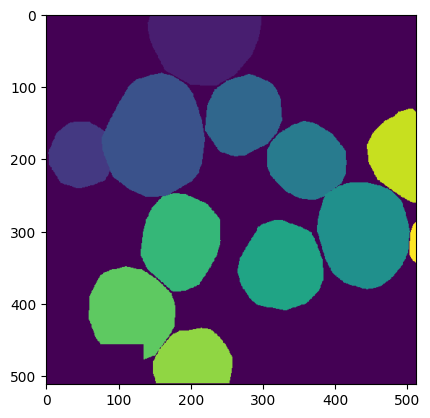

shape of array: (512, 512)


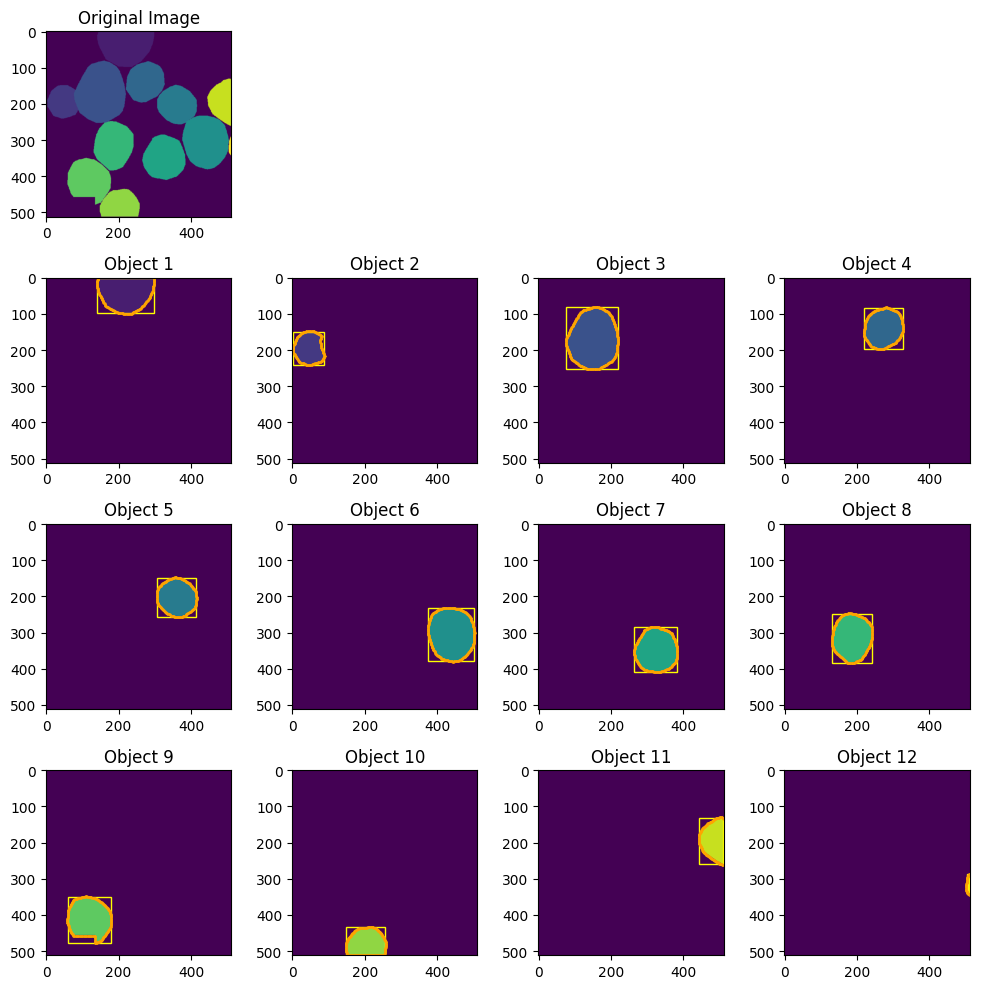

number of objects: 12


In [20]:
# choose a mask as testee
testee      = '9928dad0ac.png'
mask_testee =  Mask(os.path.join(Config.patched_mask_folder,testee))

# print basic info
print(mask_testee)

# show image
mask_testee.show()

# show data array shape
print(f'shape of array: {mask_testee.data.shape}')

# display objects
#mask_testee.find_objects()
mask_testee.show_objects()

# show objects info
print(f'number of objects: {len(mask_testee.objects_list)}')

In [21]:
object_testee = mask_testee.objects_list[0]
print(object_testee)

Object ID:     1
Object area:   12416
Object bbox:   [np.int64(140), np.int64(0), np.int64(158), np.int64(98)]
Object border: [144, 0, 299, 0, 143, 1, 144, 1, 299, 1, 143, 2, 299, 2, 142, 3, 143, 3, 298, 3, 299, 3, 142, 4, 298, 4, 142, 5, 298, 5, 142, 6, 298, 6, 141, 7, 142, 7, 298, 7, 141, 8, 298, 8, 141, 9, 298, 9, 140, 10, 141, 10, 298, 10, 139, 11, 140, 11, 298, 11, 139, 12, 298, 12, 139, 13, 140, 13, 298, 13, 140, 14, 298, 14, 140, 15, 298, 15, 140, 16, 297, 16, 298, 16, 140, 17, 297, 17, 140, 18, 297, 18, 140, 19, 297, 19, 140, 20, 297, 20, 140, 21, 297, 21, 140, 22, 296, 22, 297, 22, 140, 23, 296, 23, 140, 24, 141, 24, 296, 24, 141, 25, 296, 25, 141, 26, 296, 26, 141, 27, 296, 27, 141, 28, 142, 28, 295, 28, 296, 28, 142, 29, 295, 29, 142, 30, 295, 30, 142, 31, 295, 31, 142, 32, 294, 32, 295, 32, 142, 33, 294, 33, 142, 34, 143, 34, 294, 34, 143, 35, 294, 35, 143, 36, 294, 36, 143, 37, 144, 37, 293, 37, 294, 37, 144, 38, 292, 38, 293, 38, 144, 39, 292, 39, 144, 40, 145, 40, 292, 4

## 3.3.2 Extract COCO file
- Format reference: [LinK](https://cocodataset.org/#format-data)

In [22]:
## Initialize COCO dictionary
coco_dict = {
    "info":         {},
    "images":       [],
    "annotations":  [],
    "categories":   [],
    "categories":   [],
    "licenses":     []
}

## Build graph name list
graph_name_list = get_filenames_from_folder(Config.image_folder)
graph_name_list = graph_name_list

## Excution
# initial
annotation_id = 1  # id fpr objects, COCO 需要唯一的 annotation ID
img_index = 0

# loop
for graph_name in tqdm(graph_name_list):
    try:
        # 读取图像
        image_path = os.path.join(Config.image_folder, f'{graph_name}.png')
        mask_path  = os.path.join(Config.mask_folder, f'{graph_name}.png')

        # 读取图像信息
        image_exe       = Image(image_path)
        image_exe_shape = image_exe.data.shape
        width           = image_exe_shape[0]
        height          = image_exe_shape[1]

        # 读取 Mask 并解析其包含的 objects
        mask_exe     = Mask(mask_path)        # 创建被解析的 mask
        mask_exe.find_objects()               # 解析 mask，返回对象信息

        # step 1️⃣: ADD image to COCO file
        coco_dict["images"].append({
            "id":           img_index,
            "file_name":    f'{graph_name}.png',
            "width":        width,
            "height":       height
        })

        # 遍历 Mask 解析出的对象
        for obj_i in mask_exe.objects_list:

            # COCO 格式要求多边形至少 3 个点
            if len(obj_i.border) < 6:
                print(f'⚠️: Graph-{graph_name}-object-{obj_i.id}: Segment has less than 3 points')
                continue

            # step 2️⃣: ADD Annotation to COCO file
            coco_dict["annotations"].append({
                "id":             annotation_id,
                "image_id":       img_index,
                "category_id":    1,
                "segmentation":   [obj_i.border],                       # : [polygon1,polygon2] ... polygon = [x1,y1,x2,y2]
                "area":           obj_i.area,
                "bbox":           obj_i.bbox, # bonding box
                "iscrowd":        0                                     # 0: Obkect instance represents a single object not a collection of objects,  here, polygons are used
            })

            # step 3️⃣: ADD catagories
            coco_dict['categories'].append({
                "id":             annotation_id,
                "name":           str(annotation_id), # TODO: modify
                "supercategory":  f'{graph_name}'     # TODO: modify
            })


            # 计数
            annotation_id += 1

        img_index += 1

    except Exception as e:
        print(f'❌ Error: graph name = {graph_name}, index = {img_index}/{len(graph_name_list)}')
        print(e)

 37%|███▋      | 159/434 [00:20<00:32,  8.37it/s]

⚠️: Graph-065d8e352c-object-31: Segment has less than 3 points


 64%|██████▎   | 276/434 [00:31<00:16,  9.65it/s]

⚠️: Graph-4cd9e65aae-object-2: Segment has less than 3 points
⚠️: Graph-4cd9e65aae-object-7: Segment has less than 3 points


 97%|█████████▋| 423/434 [00:52<00:01,  9.18it/s]

⚠️: Graph-60c63e2383-object-1: Segment has less than 3 points
⚠️: Graph-60c63e2383-object-2: Segment has less than 3 points
⚠️: Graph-60c63e2383-object-106: Segment has less than 3 points


100%|██████████| 434/434 [00:54<00:00,  7.98it/s]


In [23]:
# check coco file
idx = 0
print(coco_dict['images'][idx])
print(coco_dict['annotations'][idx])

{'id': 0, 'file_name': '5c244a9ea8.png', 'width': 512, 'height': 669}
{'id': 1, 'image_id': 0, 'category_id': 1, 'segmentation': [[277, 157, 278, 157, 279, 157, 280, 157, 274, 158, 275, 158, 276, 158, 277, 158, 280, 158, 281, 158, 282, 158, 283, 158, 284, 158, 285, 158, 286, 158, 287, 158, 288, 158, 289, 158, 273, 159, 274, 159, 289, 159, 290, 159, 291, 159, 271, 160, 272, 160, 273, 160, 291, 160, 292, 160, 293, 160, 270, 161, 271, 161, 293, 161, 294, 161, 295, 161, 296, 161, 269, 162, 270, 162, 296, 162, 269, 163, 296, 163, 297, 163, 268, 164, 269, 164, 297, 164, 298, 164, 268, 165, 298, 165, 299, 165, 268, 166, 299, 166, 268, 167, 299, 167, 300, 167, 268, 168, 300, 168, 301, 168, 268, 169, 301, 169, 302, 169, 268, 170, 302, 170, 303, 170, 268, 171, 303, 171, 304, 171, 268, 172, 269, 172, 304, 172, 269, 173, 304, 173, 305, 173, 269, 174, 305, 174, 306, 174, 269, 175, 306, 175, 307, 175, 269, 176, 307, 176, 308, 176, 269, 177, 308, 177, 309, 177, 269, 178, 309, 178, 269, 179, 270, 179,

In [24]:
## Save COCO file
coco_output_path = os.path.join(Config.coco_output_folder, "coco_annotations.json")
with open(coco_output_path, "w") as f:
    json.dump(coco_dict, f, indent=4, default=lambda obj: int(obj) if isinstance(obj, np.int64) else obj)
print(f"✅ COCO annotation file saved at: {coco_output_path}")

✅ COCO annotation file saved at: /content/coco_annotations.json


### 3.2.3 Post treatment

In [25]:
%%capture
# reload package
# for avoiding conflict between self-defined Image class and imported PIL-Image package in following steps
! yes | pip uninstall pillow
! yes | pip install pillow
from PIL import Image

## 3.4 Data preprocessing
- RGB to Gray Scale
- Data Augmentation
- Transfer to Tensor

Define classes

In [26]:
class ImageDataset:
    def __init__(self, image_folder: str, mask_folder: str,transform =None,binary=False):
        '''
        Parameters:
        image_folder: path to folder containing images
        mask_folder: path to folder containing masks
        '''
        self.image_folder = image_folder
        self.mask_folder  = mask_folder
        self.image_files  = sorted(os.listdir(image_folder))
        self.mask_files   = sorted(os.listdir(mask_folder))
        self.transform    = transform
        self.binary       = binary
        # We need to use those file names to clean the data
        self.removed_filename = [
                "0ca41ed5b8","0e41d62d5d","1e011bd992","1ff313314c","2dadb1ced1",
                "3a0a2f5edf","5a65f9eba2","5eb66b74ea","6d1574872b","7a48f5b4d5",
                "7b76562318","8dffc01cc2","9c9d1af243","9d358e8c8a","43be4d0a2c",
                "51f82fcb93","62e729e838","74ef917e76","78bda6c73b","427ebc9e15",
                "671b7c8831","848b740671","2387be5eaf","7701ac03c1","a4027c076c",
                "ae690251d5","b392e4784f","bbb27830b9","c812c93fbd","c363833ad2",
                "eed04b7d68"
              ]
        self.cleaned_image_files = sorted([f for f in os.listdir(image_folder) if os.path.splitext(f)[0] not in self.removed_filename])
        self.cleaned_mask_files = sorted([f for f in os.listdir(mask_folder) if os.path.splitext(f)[0] not in self.removed_filename])

    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array        = np.array(mask)
        binary_mask       = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): # Dunder method, usage: len(obj)
      return len(self.image_files)

    def __getitem__(self, idx,clean='False'): # Dunder method, usage: obj[idx]
      if clean == 'False':
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path  = os.path.join(self.mask_folder, self.mask_files[idx])
      else:
        image_path = os.path.join(self.image_folder, self.cleaned_image_files[idx])
        mask_path  = os.path.join(self.mask_folder, self.cleaned_mask_files[idx])
      image      = Image.open(image_path).convert('L')
      mask       = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask

    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

class SegmentationTransform:
    """ Class for transforming data:
      1. Resizing
      2. Converting to tensor
    """
    def __init__(self, resize=None):
        self.resize         = resize
        self.image_resize   = transforms.Resize(resize)
        self.mask_resize    = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor  = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor

In [27]:
class ExpandedRotationDataset(Dataset):
    '''
    '''
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.base_len = len(self.base_dataset)
        # Copy attributes if needed
        self.image_files = self.base_dataset.image_files
        self.mask_files = self.base_dataset.mask_files

        # We now have 10 transformations per original image:
        # 0-3: rotations (0°, 90°, 180°, 270°)
        # 4-7: translations (random within ±50 pixels)
        # 8-9: shears (e.g., +20° and -20°)
        self.num_transforms = 10

    def __len__(self):
        return self.base_len * self.num_transforms

    def __getitem__(self, idx):
        transform_group = idx % self.num_transforms
        original_idx    = idx // self.num_transforms

        image, mask     = self.base_dataset[original_idx]

        img_np          = (image.squeeze().numpy() * 255).astype('uint8')
        pil_image       = Image.fromarray(img_np, mode='L')
        msk_np          = (mask.numpy() * 255).astype('uint8')
        pil_mask        = Image.fromarray(msk_np, mode='L')

        # Default transformation parameters
        angle       = 0
        translate   = (0, 0)
        scale       = 1.0
        shear       = 0

        if transform_group in [0, 1, 2, 3]:
            # Rotations
            angle     = transform_group * 90
            # We'll use PIL's rotate method for rotations
            pil_image = pil_image.rotate(angle, expand=True)
            pil_mask  = pil_mask.rotate(angle, expand=True)

        elif transform_group in [4, 5, 6, 7]:
            # Translations
            # Use a seeded RNG for reproducibility
            rng       = np.random.RandomState(original_idx * 100 + transform_group)
            # Random x and y translations, each within ±50 pixels
            tx        = rng.randint(-50, 51)
            ty        = rng.randint(-50, 51)
            translate = (tx, ty)

            # We can use torchvision's affine for consistent transformations
            pil_image   = TF.affine(pil_image, angle=0, translate=translate, scale=1.0, shear=0)
            pil_mask    = TF.affine(pil_mask, angle=0, translate=translate, scale=1.0, shear=0)

        elif transform_group in [8, 9]:
            # Shears
            # For example, +20° shear for transform_group = 8, and -20° shear for transform_group = 9
            shear_angle   = 20 if transform_group == 8 else -20
            # Apply shear with no rotation or translation
            pil_image     = TF.affine(pil_image, angle=0, translate=(0,0), scale=1.0, shear=shear_angle)
            pil_mask      = TF.affine(pil_mask, angle=0, translate=(0,0), scale=1.0, shear=shear_angle)

        # After applying transformations, convert to tensors
        if self.base_dataset.transform:
            image_tensor, mask_tensor = self.base_dataset.transform(pil_image, pil_mask)
        else:
            image_tensor  = torch.tensor(np.array(pil_image), dtype=torch.float32).unsqueeze(0) / 255.0
            binary_mask   = (np.array(pil_mask) > 0).astype(np.float32)
            mask_tensor   = torch.tensor(binary_mask)

        return image_tensor, mask_tensor

    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]

        # Filter valid indices
        idx = [i for i in idx if i < len(self)]

        total_cols  = 3 if (mask and overlay) else (2 if mask else 1)
        total_rows  = len(idx)
        fig, axes   = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]
            img_np = img.squeeze(0).numpy()
            mask_np = mask_img.numpy()

            transform_group = file_idx % self.num_transforms
            original_idx = file_idx // self.num_transforms

            # Determine transformation type for title
            if transform_group in [0,1,2,3]:
                angle = transform_group * 90
                title_transform   = f"Rot {angle}°"
            elif transform_group in [4,5,6,7]:
                title_transform   = "Translation"
            elif transform_group  == 8:
                title_transform   = "Shear +20°"
            else:
                title_transform = "Shear -20°"

            img_name = self.image_files[original_idx]
            mask_name = self.mask_files[original_idx]

            ax_row = axes[i] if total_rows > 1 else axes

            # Show the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {img_name} ({title_transform})")
            ax_row[0].axis('off')

            if mask:
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {mask_name} ({title_transform})")
                ax_row[1].axis('off')

                if overlay:
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

# 4.Data Loader

In [28]:
# Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended

# Original data
# select prestine data
'''
origianl_dataset      = ImageDataset(config.image_folder, # path to image folder
                                     config.mask_folder,  # path to mask folder
                                     transform=transform,
                                     binary=True)
'''
# select patched data
origianl_dataset      = ImageDataset(config.patched_image_folder, # path to image folder
                                     config.patched_mask_folder,  # path to mask folder
                                     transform=transform,
                                     binary=True)


original_dataset_size = len(origianl_dataset)
train_size_original   = int(0.6 * original_dataset_size)
val_size_original     = int(0.2 * original_dataset_size)
test_size_original    = original_dataset_size - train_size_original - val_size_original

# Original
train_dataset_original, val_dataset_original, test_dataset_original = random_split(
    origianl_dataset,[train_size_original, val_size_original, test_size_original], generator=torch.Generator().manual_seed(42))

# optional augmented dataset
dataset = ExpandedRotationDataset(origianl_dataset)
dataset_size = len(dataset)
"""
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
"""
train_original_indices = train_dataset_original.indices
val_original_indices = val_dataset_original.indices
test_original_indices = test_dataset_original.indices
train_indices = []
for i in train_original_indices:
    for j in range(10):
        train_indices.append(i * 10 + j)

val_indices = []
for i in val_original_indices:
    for j in range(10):
        val_indices.append(i * 10 + j)

test_indices = []
for i in test_original_indices:
    for j in range(10):
        test_indices.append(i * 10 + j)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Data loaders
"""
We can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
train_loader_original = DataLoader(train_dataset_original,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader_original = DataLoader(val_dataset_original,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader_original = DataLoader(test_dataset_original,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
# dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [29]:
# print all the indices to check if they are correct!!!

# Save original split indices
pd.DataFrame(train_original_indices).to_csv('train_original_indices.csv', index=False, header=["index"])
pd.DataFrame(val_original_indices).to_csv('val_original_indices.csv', index=False, header=["index"])
pd.DataFrame(test_original_indices).to_csv('test_original_indices.csv', index=False, header=["index"])

# Save augmented (rotated) dataset indices
pd.DataFrame(train_indices).to_csv('train_augmented_indices.csv', index=False, header=["index"])
pd.DataFrame(val_indices).to_csv('val_augmented_indices.csv', index=False, header=["index"])
pd.DataFrame(test_indices).to_csv('test_augmented_indices.csv', index=False, header=["index"])

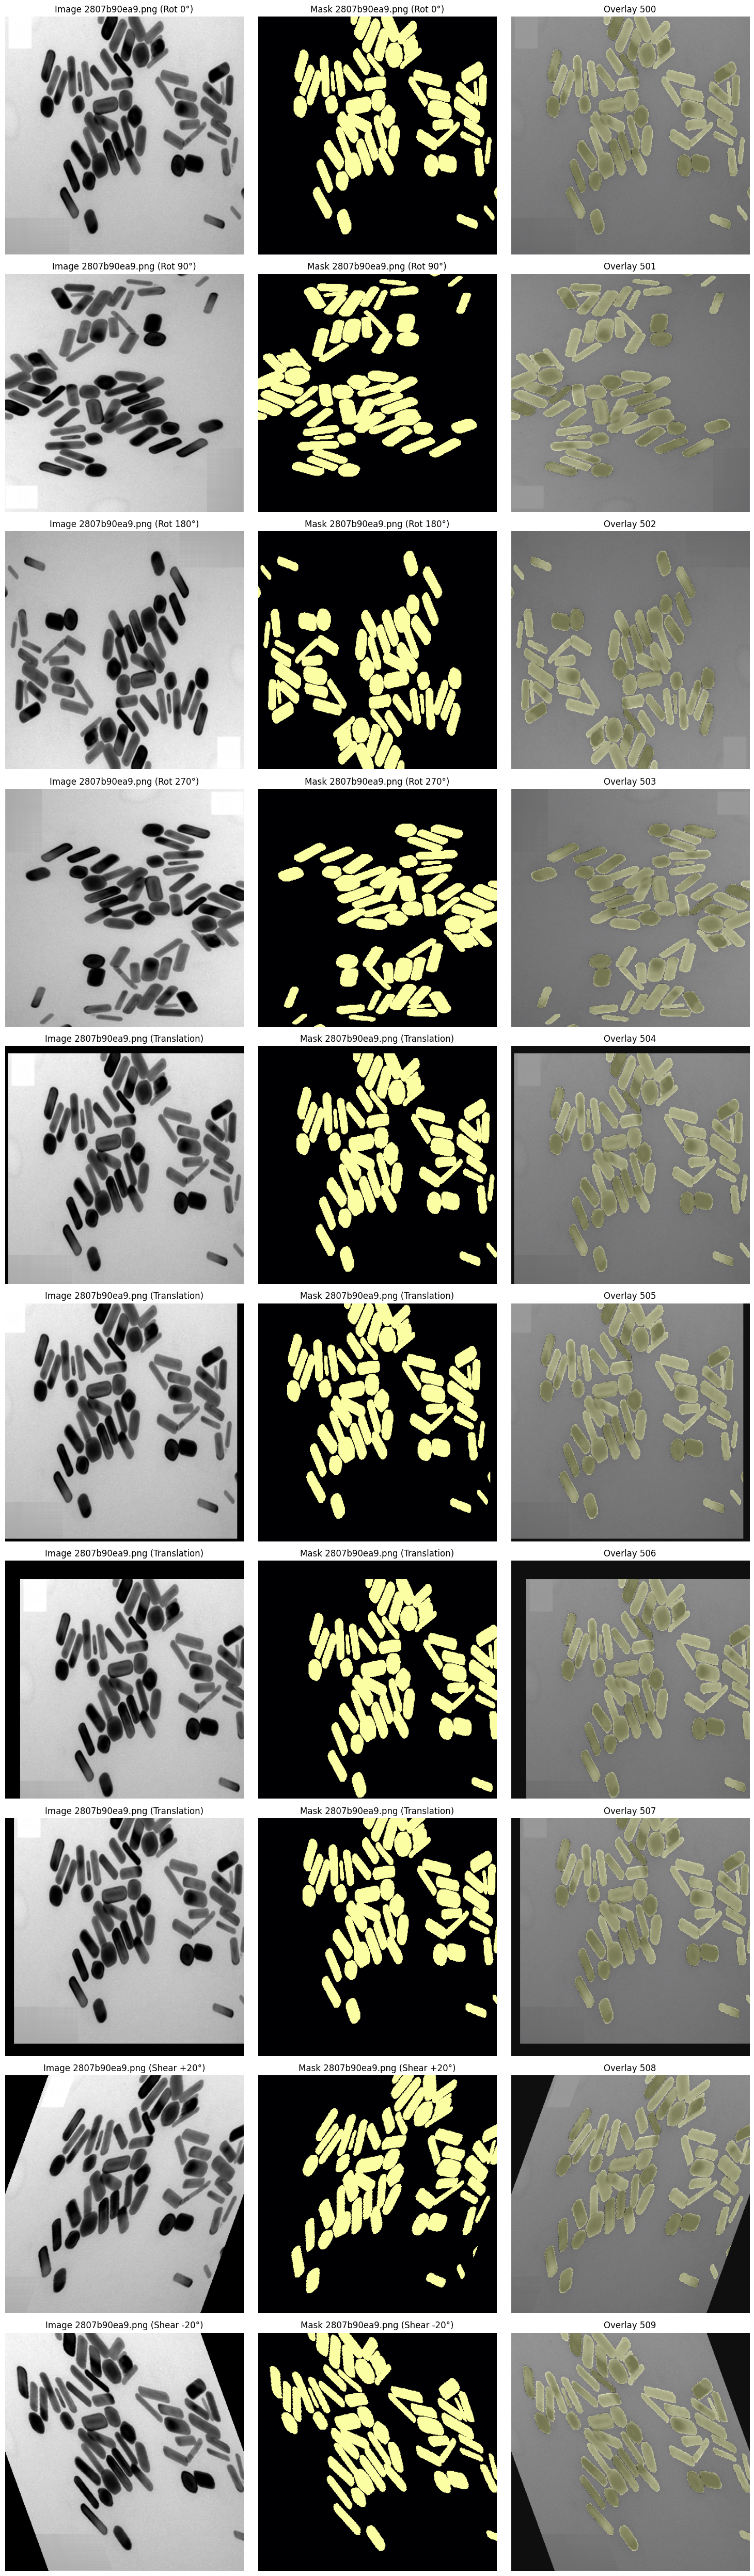

In [30]:
selected_train_idxs = train_indices[:10]
dataset.plot_figure(idx=selected_train_idxs, overlay=True, mask=True, binary=True)

In [31]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)

np.float32(1.0)

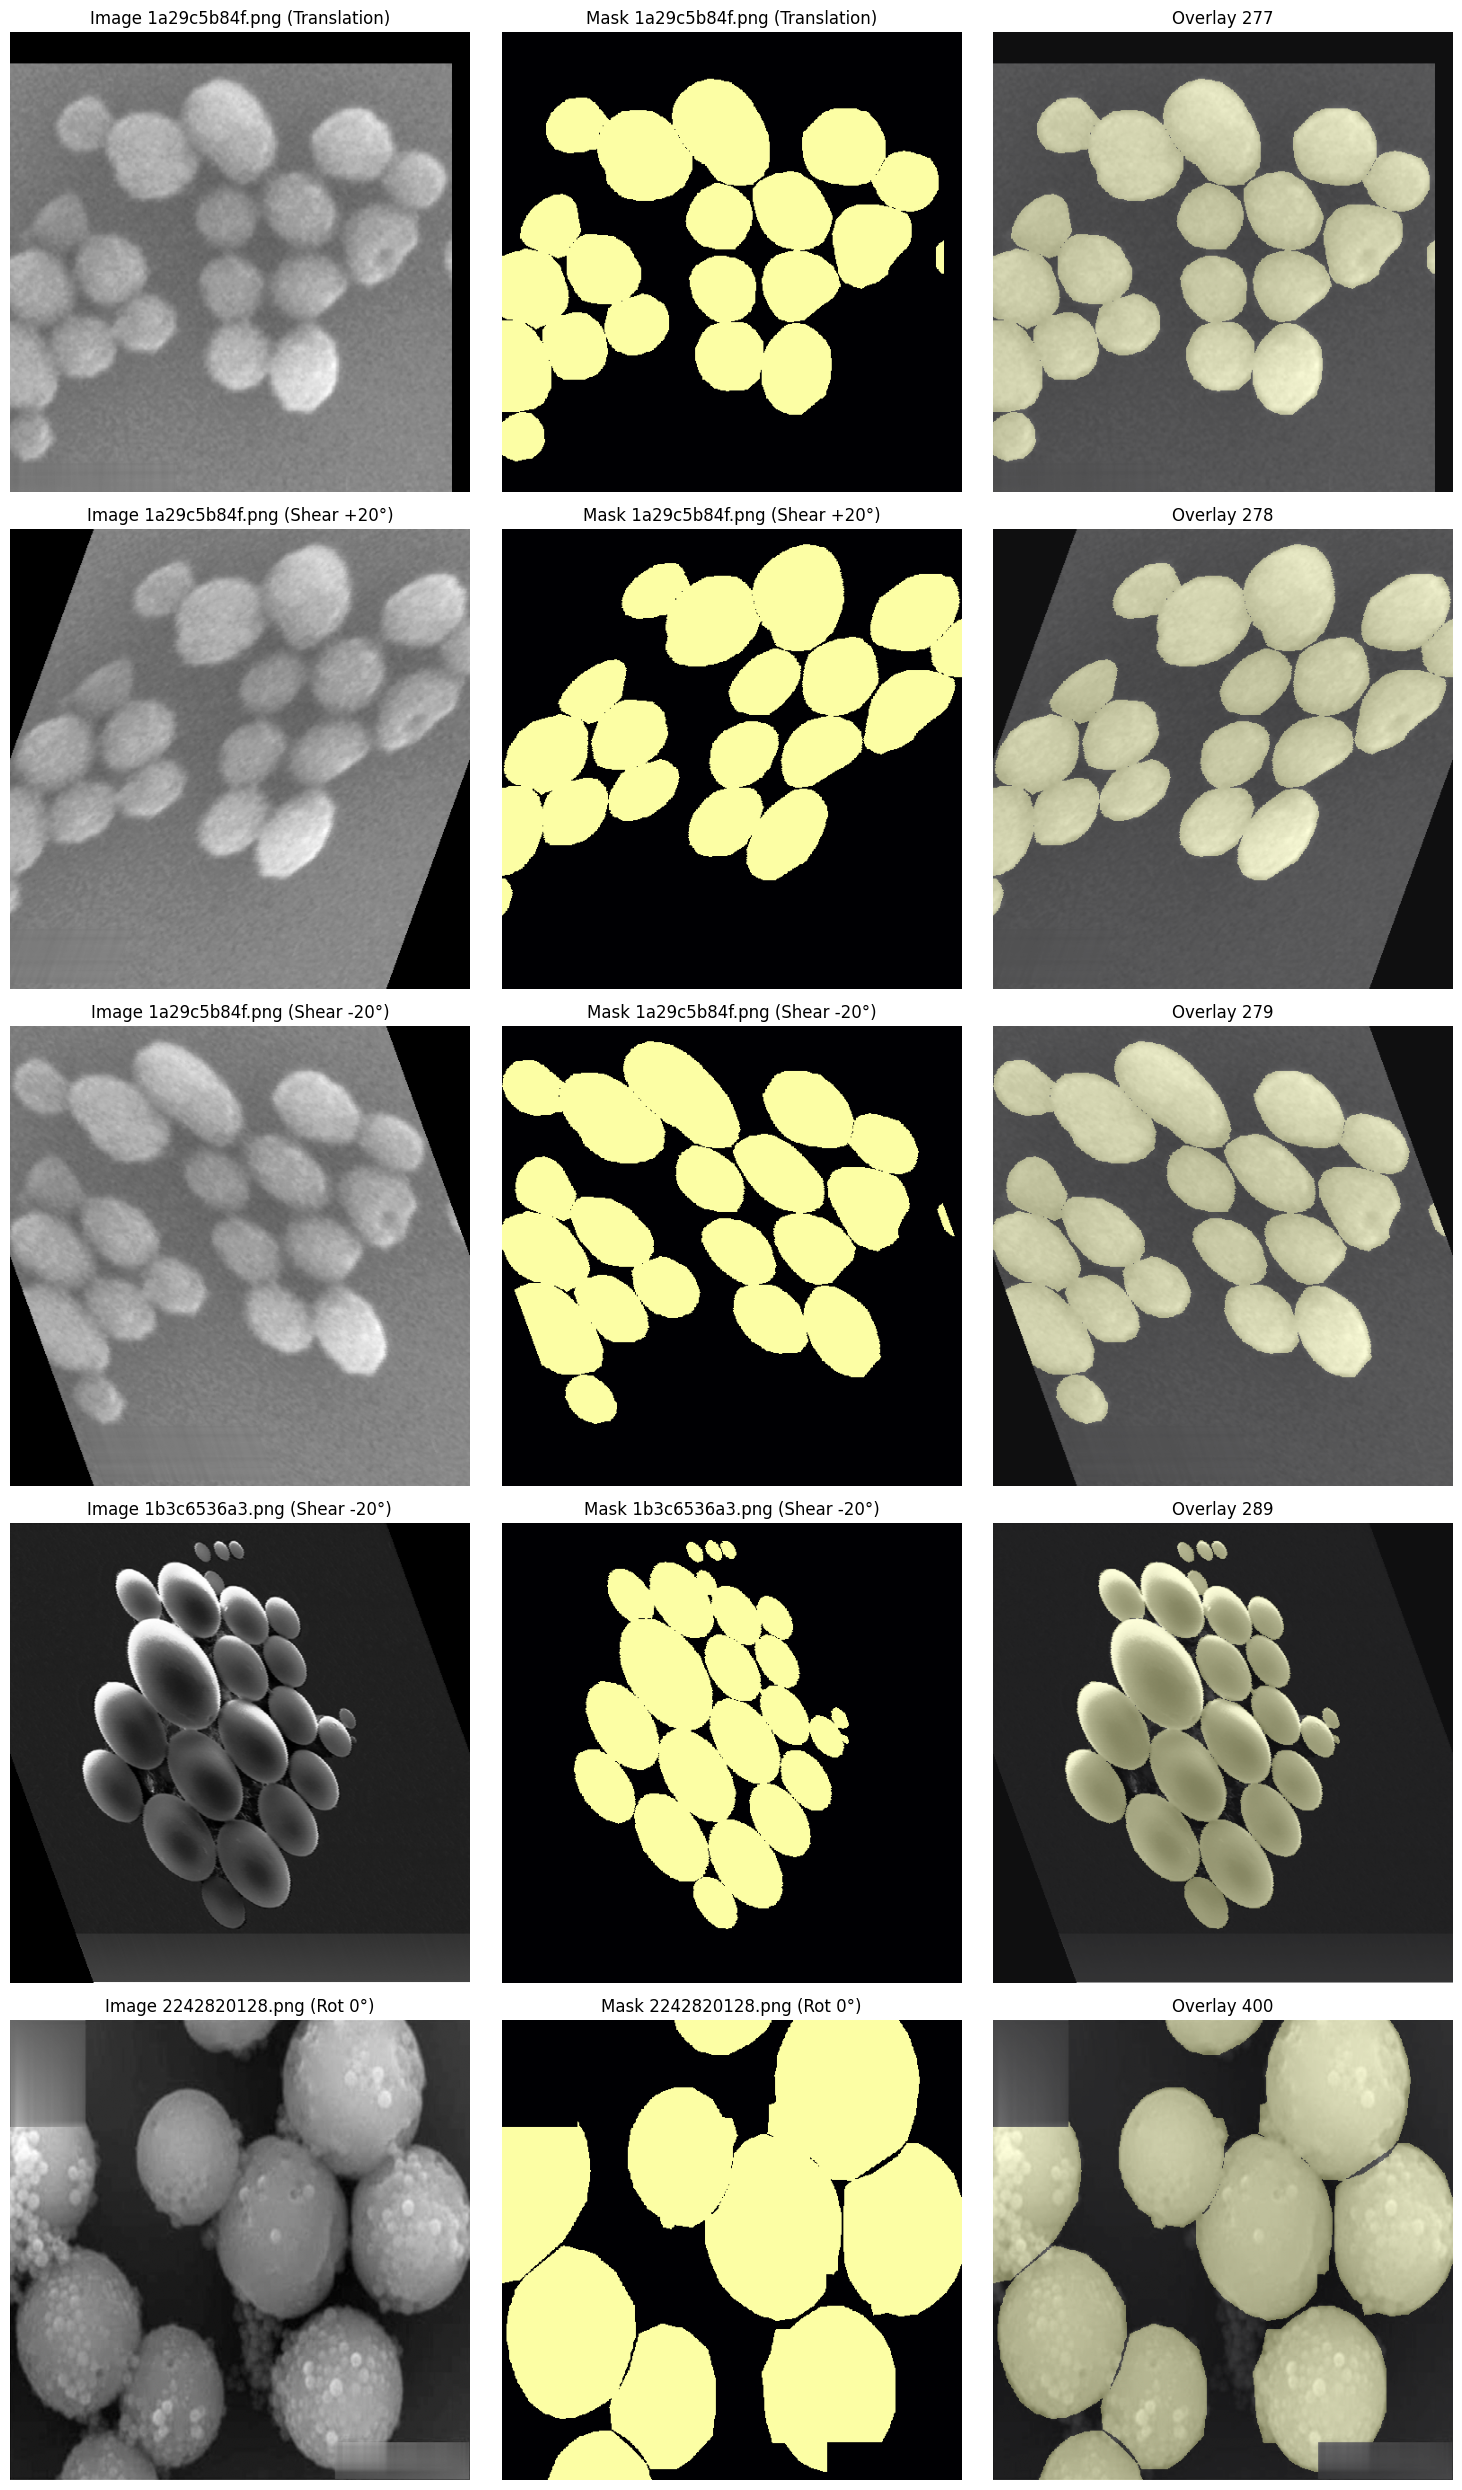

In [32]:
dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[277,278,279,289,400])

# 5.Model preparation


##5.1 VGG-16


In [33]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]


##5.2 ResNet-50

In [34]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 187MB/s]


##5.3 U-Net

In [35]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',                  # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',               # Use pretrained weights from ImageNet
    in_channels=1,                            # Input channels (RGB images)
    classes=config.num_classes,               # Number of output classes
    encoder_depth=5,                          # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 383MB/s]


##5.4 DeepLabv3+


In [36]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 219MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [37]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


##5.7 Attention-Res-YNet

In [38]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

## 5.8 Attention-YNet

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x_enc = self.layer4(x4)
        return x_enc, [x0, x1, x2, x3, x4]

class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)

class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features

        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)

        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)

        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)

        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)

        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)

        output = self.final_conv(x)
        return output

class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)

        # After encoder:
        # x_enc: 512 channels
        # x4: 256 channels, x3:128 channels, x2:64 channels, x1:64 channels
        # Total = 1024 channels
        self.bottleneck_reduce = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)

        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x0, x1, x2, x3, x4 = encoder_features

        # Match spatial sizes to x_enc
        h, w = x_enc.size(2), x_enc.size(3)
        x4 = F.interpolate(x4, size=(h, w), mode='bilinear', align_corners=False)
        x3 = F.interpolate(x3, size=(h, w), mode='bilinear', align_corners=False)
        x2 = F.interpolate(x2, size=(h, w), mode='bilinear', align_corners=False)
        x1 = F.interpolate(x1, size=(h, w), mode='bilinear', align_corners=False)

        # Now concatenate
        x_combined_features = torch.cat([x_enc, x4, x3, x2, x1], dim=1)

        x_bottleneck_input = self.bottleneck_reduce(x_combined_features)
        x_bottleneck1 = self.bottleneck1(x_bottleneck_input)
        x_bottleneck2 = self.bottleneck2(x_bottleneck_input)

        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)

        # Pass combined to decoder along with original encoder features
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

# 6.Training and testing

In [40]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 10:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 10 <= epoch < 15:
        return 0.5
    elif 15 <= epoch < 20:
        return 0.2
    #elif 50 <= epoch < 70:
        #return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

from segmentation_models_pytorch.losses import FocalLoss

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0, weight_focal=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = weight_dice
        self.bce_weight = weight_bce
        self.focal_weight = weight_focal
        self.focal_loss = FocalLoss(mode='binary')

    def forward(self, outputs, targets):
        # Ensure outputs and targets have the same shape
        assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"

        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        focal_loss = self.focal_loss(outputs, targets)

        total_loss = (self.bce_weight * bce_loss +
                      self.dice_weight * dice_loss +
                      self.focal_weight * focal_loss)
        return total_loss

# Instantiate the criterion
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0, weight_focal=5.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [ ]:
from sklearn.metrics import adjusted_rand_score
num_epochs = 30
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/30 - Training: 100%|██████████| 163/163 [00:42<00:00,  3.82it/s]


Epoch 1/30, Training Loss: 0.8530


Epoch 1/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]


Epoch 1/30, Validation Loss: 0.7078
Precision: 0.9506, Recall: 0.9229, Accuracy: 0.9658
IoU: 0.8590, F1 Score: 0.9365, Dice Coefficient: 0.9162
Pixel Error: 0.0342, Rand Error: 0.1552


Epoch 2/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 2/30, Training Loss: 0.4692


Epoch 2/30 - Validation: 100%|██████████| 54/54 [01:04<00:00,  1.20s/it]


Epoch 2/30, Validation Loss: 0.5158
Precision: 0.9442, Recall: 0.9588, Accuracy: 0.9732
IoU: 0.8952, F1 Score: 0.9515, Dice Coefficient: 0.9411
Pixel Error: 0.0268, Rand Error: 0.1179


Epoch 3/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 3/30, Training Loss: 0.3735


Epoch 3/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.20s/it]


Epoch 3/30, Validation Loss: 0.4704
Precision: 0.9639, Recall: 0.9472, Accuracy: 0.9759
IoU: 0.9039, F1 Score: 0.9555, Dice Coefficient: 0.9464
Pixel Error: 0.0241, Rand Error: 0.1050


Epoch 4/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 4/30, Training Loss: 0.2741


Epoch 4/30 - Validation: 100%|██████████| 54/54 [01:04<00:00,  1.20s/it]


Epoch 4/30, Validation Loss: 0.3658
Precision: 0.9651, Recall: 0.9622, Accuracy: 0.9802
IoU: 0.9142, F1 Score: 0.9637, Dice Coefficient: 0.9534
Pixel Error: 0.0198, Rand Error: 0.0922


Epoch 5/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 5/30, Training Loss: 0.2090


Epoch 5/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.20s/it]


Epoch 5/30, Validation Loss: 0.3260
Precision: 0.9695, Recall: 0.9615, Accuracy: 0.9812
IoU: 0.9182, F1 Score: 0.9655, Dice Coefficient: 0.9555
Pixel Error: 0.0188, Rand Error: 0.0875


Epoch 6/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.93it/s]


Epoch 6/30, Training Loss: 0.1646


Epoch 6/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]


Epoch 6/30, Validation Loss: 0.2863
Precision: 0.9810, Recall: 0.9491, Accuracy: 0.9810
IoU: 0.9158, F1 Score: 0.9648, Dice Coefficient: 0.9539
Pixel Error: 0.0190, Rand Error: 0.0888


Epoch 7/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 7/30, Training Loss: 0.2330


Epoch 7/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]


Epoch 7/30, Validation Loss: 0.3464
Precision: 0.9357, Recall: 0.9357, Accuracy: 0.9648
IoU: 0.8820, F1 Score: 0.9357, Dice Coefficient: 0.9306
Pixel Error: 0.0352, Rand Error: 0.1401


Epoch 8/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.93it/s]


Epoch 8/30, Training Loss: 0.1656


Epoch 8/30 - Validation: 100%|██████████| 54/54 [01:06<00:00,  1.23s/it]


Epoch 8/30, Validation Loss: 0.2372
Precision: 0.9714, Recall: 0.9661, Accuracy: 0.9830
IoU: 0.9217, F1 Score: 0.9688, Dice Coefficient: 0.9573
Pixel Error: 0.0170, Rand Error: 0.0820


Epoch 9/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 9/30, Training Loss: 0.1303


Epoch 9/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]


Epoch 9/30, Validation Loss: 0.2190
Precision: 0.9731, Recall: 0.9663, Accuracy: 0.9835
IoU: 0.9229, F1 Score: 0.9697, Dice Coefficient: 0.9577
Pixel Error: 0.0165, Rand Error: 0.0802


Epoch 10/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.94it/s]


Epoch 10/30, Training Loss: 0.1144


Epoch 10/30 - Validation: 100%|██████████| 54/54 [01:06<00:00,  1.22s/it]


Epoch 10/30, Validation Loss: 0.2165
Precision: 0.9655, Recall: 0.9748, Accuracy: 0.9836
IoU: 0.9246, F1 Score: 0.9701, Dice Coefficient: 0.9593
Pixel Error: 0.0164, Rand Error: 0.0790


Epoch 11/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.92it/s]


Epoch 11/30, Training Loss: 0.1025


Epoch 11/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.22s/it]


Epoch 11/30, Validation Loss: 0.2028
Precision: 0.9749, Recall: 0.9664, Accuracy: 0.9840
IoU: 0.9276, F1 Score: 0.9707, Dice Coefficient: 0.9610
Pixel Error: 0.0160, Rand Error: 0.0764


Epoch 12/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.93it/s]


Epoch 12/30, Training Loss: 0.0968


Epoch 12/30 - Validation: 100%|██████████| 54/54 [01:06<00:00,  1.22s/it]


Epoch 12/30, Validation Loss: 0.1969
Precision: 0.9741, Recall: 0.9702, Accuracy: 0.9848
IoU: 0.9280, F1 Score: 0.9721, Dice Coefficient: 0.9611
Pixel Error: 0.0152, Rand Error: 0.0742


Epoch 13/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.93it/s]


Epoch 13/30, Training Loss: 0.0919


Epoch 13/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.22s/it]


Epoch 13/30, Validation Loss: 0.1991
Precision: 0.9704, Recall: 0.9709, Accuracy: 0.9839
IoU: 0.9256, F1 Score: 0.9706, Dice Coefficient: 0.9598
Pixel Error: 0.0161, Rand Error: 0.0776


Epoch 14/30 - Training: 100%|██████████| 163/163 [00:41<00:00,  3.93it/s]


Epoch 14/30, Training Loss: 0.0906


Epoch 14/30 - Validation: 100%|██████████| 54/54 [01:05<00:00,  1.21s/it]


Epoch 14/30, Validation Loss: 0.1866
Precision: 0.9757, Recall: 0.9687, Accuracy: 0.9848
IoU: 0.9268, F1 Score: 0.9722, Dice Coefficient: 0.9604
Pixel Error: 0.0152, Rand Error: 0.0748


Epoch 15/30 - Training:  12%|█▏        | 20/163 [00:05<00:35,  4.02it/s]

##6.2 Testing



In [ ]:
model.eval()
test_loss = 0.0
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        tp = (preds * masks).sum().item()
        fp = (preds * (1 - masks)).sum().item()
        fn = ((1 - preds) * masks).sum().item()
        tn = ((1 - preds) * (1 - masks)).sum().item()
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


In [ ]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [ ]:
# Save the model
torch.save(model.state_dict(), 'AttentionUNet_cleandata.pth')

# Load the model
model.load_state_dict(torch.load('AttentionUNet_cleandatal.pth'))
model.eval()

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



In [ ]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader_original))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)